## 1. Set up

In [1]:
import pandas as pd
import os
import base64
import time
import pickle as p
import numpy as np
import matplotlib.pyplot as plt
import pandas.core.algorithms as algos
from sklearn.model_selection import train_test_split
from sklearn import metrics
from functools import reduce
import datetime
from dateutil.relativedelta import relativedelta
import logging
import matplotlib.style as style
import matplotlib
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
import gc
gc.collect()

51

## 2. Data Loading & Preprocessing

In [4]:
data_file_path = '../data/'

### 2.1 TPA & Client

In [5]:
# Client & TPA

TPA = pd.read_excel(data_file_path + 'Copy_of_TPA_cash.xlsx',sheet_name='Sheet1')
Client = pd.read_excel(data_file_path + 'Client_info_20191118.xlsx',sheet_name='Sheet1')
# 3 Clients have duplicates records
# Client[Client['Client ID'].isin([1500,7601,2449])]
Client = Client.drop(Client.index[[0,1,497]])


Client = Client.merge(TPA,how='left',left_on='Client ID',right_on='HOST ID')
Client['TPA'] = Client['TPA_x']
Client.loc[Client['TPA_x'].isnull(),'TPA'] = Client.loc[Client['TPA_x'].isnull(),'TPA_y']
Client['TPA'] = Client['TPA'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Client.drop(['TPA_x','TPA_y','HOST ID'],axis=1,inplace = True)

In [6]:
# You might want to delete TPA, uncomment following line
# del TPA

### 2.2 Customer

In [7]:
Customer_old = pd.read_csv(data_file_path + 'Customer_Data_Request_20191121.csv')
Customer = pd.read_csv(data_file_path + 'Customer_Data_Request_20191217.csv')
# Append these 2 dataframes together
Customer = Customer_old.append(Customer,ignore_index = True)


# 2 Customer has duplicating records, we pick ClientID 2049 as their real Client but this is just a random choice
# Customer[Customer['Unique_Customer_ID']==100541023,100696306]
# Drop the duplicates customerID by index
Customer = Customer.drop(Customer.index[[72898,51730]])

# This line is self-explained
Customer = Customer.replace('.', np.nan)


# ===================== #
# Formatting conversion #
# ===================== #
def f(x):
    """
    This is a function that takes in any string format variable
    and return it as uppercase format.
    
    """
    if pd.notnull(x):
        return x.upper()
    else:
        return np.nan

Customer['Street1'] = Customer['Street1'].apply(lambda x: f(x))
Customer['Street2'] = Customer['Street2'].apply(lambda x: f(x))
Customer['City'] = Customer['City'].apply(lambda x: f(x))
Customer['Status'] = Customer['Status'].apply(lambda x: f(x))

# Convert numeric columns to float type
Customer_numeric_columns = ['Customer_Salary','Customer_Tenure']
Customer[Customer_numeric_columns] = Customer[Customer_numeric_columns].astype(float)

# Convert date format columns to datetime type
Customer_date_columns = ['Enrollment_Date','Term_Date']
Customer[Customer_date_columns] = Customer[Customer_date_columns].astype(str).apply(pd.to_datetime, format='%m/%d/%Y')

# Some data cleaning here, eliminate the customers with following cases
# Customer_Salary has NaN, 0 and '.' ~11%
# Assigned_Spending_Limit has 0 ~7%
# Customer_Tenure has NaN

# Customer = Customer[(Customer['Assigned_Spending_Limit'] != 0) & 
#                     (Customer['Customer_Salary'] != 0) & 
#                     (Customer['Customer_Salary'].notnull())&
#                     (Customer['Customer_Tenure'].notnull())]




# Merge Customer dataset with Client by Company ID/Client ID
Customer = Customer.merge(Client,how='left',left_on='Unique_Company_ID',right_on='Client ID')
Customer.head()


Unique_Customer_ID  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary Prior_Customer_Flag                 Street1 Street2           City State    Zip    Status Term_Date Active  Client ID                    Account Name  Current Eligibles  Eligibles at time of Launch                         Industry  NAICS Code                                  NAICS Description Broker Launch Date Termination Date Affiliate/Fed Gov? CLIENT CODE                     CLIENT NAME         CLIENT AR                                Cash  TPA
0           100001115               1000      2014-02-24                   6880.0            230.0          58229.0        Repeat Buyer          1471 N EAST ST     NaN           YORK    PA  17406  EMPLOYED       NaT      Y     1000.0  SOCIAL SECURITY ADMINISTRATION            60000.0                      70000.0  Federal Government/Associations    923130.0  Administration of Social, Human Resource and I...    PPC  2002-07-01              NaT            Fed Gov         SSA  SOCIAL SECURITY ADMINISTRATION  KELLY MENCHINGER  TPA sends cash on behalf of client  EAA
1           100001120               1000      2014-02-24                   6520.0            362.0         109245.0        Repeat Buyer         94 BRENTWOOD LN     NaN  VALLEY STREAM    NY  11581  EMPLOYED       NaT      Y     1000.0  SOCIAL SECURITY ADMINISTRATION            60000.0                      70000.0  Federal Government/Associations    923130.0  Administration of Social, Human Resource and I...    PPC  2002-07-01              NaT            Fed Gov         SSA  SOCIAL SECURITY ADMINISTRATION  KELLY MENCHINGER  TPA sends cash on behalf of client  EAA
2           100001141               1000      2014-02-25                  10290.0            337.0         127226.0        Repeat Buyer  103 KENILWORTH PARK DR  APT 2B         TOWSON    MD  21204  EMPLOYED       NaT      Y     1000.0  SOCIAL SECURITY ADMINISTRATION            60000.0                      70000.0  Federal Government/Associations    923130.0  Administration of Social, Human Resource and I...    PPC  2002-07-01              NaT            Fed Gov         SSA  SOCIAL SECURITY ADMINISTRATION  KELLY MENCHINGER  TPA sends cash on behalf of client  EAA
3           100001158               1000      2014-02-24                   5190.0            419.0          49375.0        Repeat Buyer       1036 BRADDISH AVE     NaN      BALTIMORE    MD  21216  EMPLOYED       NaT      Y     1000.0  SOCIAL SECURITY ADMINISTRATION            60000.0                      70000.0  Federal Government/Associations    923130.0  Administration of Social, Human Resource and I...    PPC  2002-07-01              NaT            Fed Gov         SSA  SOCIAL SECURITY ADMINISTRATION  KELLY MENCHINGER  TPA sends cash on behalf of client  EAA
4           100001169               1000      2014-02-24                   7500.0            448.0          69460.0        Repeat Buyer       3915 W ROGERS AVE     NaN      BALTIMORE    MD  21215  EMPLOYED       NaT      Y     1000.0  SOCIAL SECURITY ADMINISTRATION            60000.0                      70000.0  Federal Government/Associations    923130.0  Administration of Social, Human Resource and I...    PPC  2002-07-01              NaT            Fed Gov         SSA  SOCIAL SECURITY ADMINISTRATION  KELLY MENCHINGER  TPA sends cash on behalf of client  EAA

In [8]:
print('{:.0%} of Customers have Assigned_Spending_Limit == 0'.format(Customer[Customer['Assigned_Spending_Limit']==0].shape[0]/Customer.shape[0]))
print('{:.0%} of Customers have missing Customer_Salary'.format(Customer[Customer['Customer_Salary'].isnull()].shape[0]/Customer.shape[0]))
print('{:.2%} of Customers have Customer_Salary == 0'.format(Customer[Customer['Customer_Salary']==0].shape[0]/Customer.shape[0]))
print('{:.2%} of Customers have missing Customer_Tenure'.format(Customer[Customer['Customer_Tenure'].isnull()].shape[0]/Customer.shape[0]))

7% of Customers have Assigned_Spending_Limit == 0
11% of Customers have missing Customer_Salary
0.25% of Customers have Customer_Salary == 0
0.02% of Customers have missing Customer_Tenure


### 2.3 Performance Dataset

In [9]:
Perf_11 = pd.read_csv(data_file_path + 'Performance_Data_Request_20191217.csv')
Perf = pd.read_csv(data_file_path + 'Performance_Data_Request_20191204.csv')
# Deal with the column name mismatching issue before appending the 2 dataframes together
Perf_11.rename(columns={' Unique_Order_ID': 'Unique_Order_ID',
                        'Order_date': 'Order_Date'}, inplace=True)
Perf.rename(columns={'items_ordered': 'Items_Ordered',
                     'EMPSTATUS': 'Customer_Status'}, inplace=True)
# Append these 2 dataframes together
Perf = Perf.append(Perf_11, ignore_index=True)

# This line is self-explained
Perf = Perf.replace('.', np.nan)

# ===================== #
# Formatting conversion #
# ===================== #
# Convert numeric columns to float type
Perf_numeric_columns = ['Order_Amount', 'Product_Markup', 'Payments_Due', 'Current_Balance', 'Losses', 
                   'Spending_Limit_at_time_of_Order', 'Tenure_at_time_of_Order','Salary_at_time_of_Order']
Perf[Perf_numeric_columns] = Perf[Perf_numeric_columns].astype(float)

# Convert date format columns to datetime type
Perf_date_columns = ['Date_account_went_delinquent','Order_Date']
Perf[Perf_date_columns] = Perf[Perf_date_columns].astype(str).apply(pd.to_datetime,format = '%m/%d/%Y' )


# Make sure the data order is aligned with OrderID & Y-M
Perf['Year_and_Month'] = pd.to_datetime(Perf['Year_and_Month'].astype(str), format='%Y%m')
Perf = Perf.sort_values(['Unique_Order_ID', 'Year_and_Month'], ascending=[False, True])

# ======================== #
# New Columns Construction #
# ======================== #

# Create YQ and Year
Perf['YQ'] = pd.PeriodIndex(Perf['Year_and_Month'], freq='Q')
Perf['Year'] = Perf['YQ'].dt.year

# Create Payment_Order by Unique_Order_ID and Year_and_Month
Perf['Payment_Order'] = Perf.groupby('Unique_Order_ID')['Year_and_Month'].rank(method='first')

# Create Bad Flag - Treat 151+ and CO as BAD
Perf['Bad'] = 0
Perf.loc[Perf['Default_Status'].isin(['151+', 'Chargeoff']), 'Bad'] = 1

# Create a flag Ever_Bad to distinguish first time bad and non-first time bad
# If Ever_Bad == 1, this order is bad at the first time,
# If Ever_Bad >1, this order has been bad but not at the first time
# If Ever_Bad == 0, this order is good
Perf['Ever_Bad'] = Perf.groupby('Unique_Order_ID')['Bad'].transform(pd.Series.cumsum)

# Create 2os_loss
# Note that Orders with Default_Status == Chargeoff, the corresponding Current_Balance == 0, but Losses has valid value
# while Orders with Default_Status == 151+, the corresponding Current_Balance has valid value, but Losses == 0
# Thus, we use Losses for C/O orders and Current_Balance for 151+ orders to create 2os_loss
Perf['2os_loss'] = 0
Perf.loc[Perf['Default_Status'] == 'Chargeoff',
         '2os_loss'] = Perf.loc[Perf['Default_Status'] == 'Chargeoff', 'Losses']
Perf.loc[Perf['Default_Status'] == '151+',
         '2os_loss'] = Perf.loc[Perf['Default_Status'] == '151+', 'Current_Balance']



# Perf = Perf[(Perf['Order_Amount'].notnull()) & (Perf['Order_Amount'] != 0)]

# Merge Perf dataset with Customer by Unique_Customer_ID
Perf = Perf.merge(Customer, how='left', on='Unique_Customer_ID')

In [10]:
# Well this chunk of code takes forever...


# import s3fs

# s3 = s3fs.S3FileSystem(anon=False)

# # Use 'w' for py3, 'wb' for py2
# with s3.open('power-purchasing/Perf_All.csv','w') as f:
#     Perf.to_csv(f)

In [11]:
Perf.shape

(38861289, 61)

In [12]:
P15 = Perf[Perf['Year']>=2015]

### Channel

In [15]:
'Affiliate/Fed Gov?'

'Affiliate/Fed Gov?'

In [11]:
A = P15[(P15['Bad']==1)&(P15['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Year_and_Month', columns='Affiliate/Fed Gov?',aggfunc='sum' ).reset_index().rename_axis(None, axis=1)

In [12]:
B = P15.pivot_table(values = 'Current_Balance',index = 'Year_and_Month', columns='Affiliate/Fed Gov?',aggfunc='sum' ).reset_index().rename_axis(None, axis=1)

In [13]:
Channel = A.iloc[:,1:]/B.iloc[:,1:]
Channel['Year_and_Month'] = A['Year_and_Month']
Channel['Year'] = Channel['Year_and_Month'].dt.year
Channel['Year'] = pd.to_datetime(Channel['Year'].astype(str),format='%Y')
Channel

Affiliate   Fed Gov Year_and_Month       Year
0    0.008234  0.008545     2015-01-01 2015-01-01
1    0.007395  0.007671     2015-02-01 2015-01-01
2    0.009025  0.008671     2015-03-01 2015-01-01
3    0.007951  0.007682     2015-04-01 2015-01-01
4    0.008619  0.007636     2015-05-01 2015-01-01
5    0.010400  0.008609     2015-06-01 2015-01-01
6    0.011843  0.013818     2015-07-01 2015-01-01
7    0.011866  0.013658     2015-08-01 2015-01-01
8    0.012305  0.013636     2015-09-01 2015-01-01
9    0.011803  0.012460     2015-10-01 2015-01-01
10   0.010135  0.012505     2015-11-01 2015-01-01
11   0.007727  0.010689     2015-12-01 2015-01-01
12   0.008965  0.010712     2016-01-01 2016-01-01
13   0.007841  0.009014     2016-02-01 2016-01-01
14   0.009389  0.010843     2016-03-01 2016-01-01
15   0.008506  0.009416     2016-04-01 2016-01-01
16   0.008986  0.008804     2016-05-01 2016-01-01
17   0.009748  0.010544     2016-06-01 2016-01-01
18   0.012101  0.012925     2016-07-01 2016-01-01
19   0.011959  0.012917     2016-08-01 2016-01-01
20   0.012534  0.010849     2016-09-01 2016-01-01
21   0.011962  0.012201     2016-10-01 2016-01-01
22   0.011514  0.015485     2016-11-01 2016-01-01
23   0.008827  0.008381     2016-12-01 2016-01-01
24   0.009443  0.008198     2017-01-01 2017-01-01
25   0.008594  0.007940     2017-02-01 2017-01-01
26   0.009581  0.007872     2017-03-01 2017-01-01
27   0.010068  0.008522     2017-04-01 2017-01-01
28   0.009737  0.010096     2017-05-01 2017-01-01
29   0.009456  0.009473     2017-06-01 2017-01-01
30   0.012385  0.012397     2017-07-01 2017-01-01
31   0.012704  0.011966     2017-08-01 2017-01-01
32   0.013750  0.010509     2017-09-01 2017-01-01
33   0.013564  0.014006     2017-10-01 2017-01-01
34   0.010476  0.012860     2017-11-01 2017-01-01
35   0.009974  0.010693     2017-12-01 2017-01-01
36   0.009618  0.008049     2018-01-01 2018-01-01
37   0.008908  0.007537     2018-02-01 2018-01-01
38   0.009788  0.008081     2018-03-01 2018-01-01
39   0.010134  0.008710     2018-04-01 2018-01-01
40   0.009325  0.010968     2018-05-01 2018-01-01
41   0.010580  0.012052     2018-06-01 2018-01-01
42   0.012634  0.015062     2018-07-01 2018-01-01
43   0.013101  0.015710     2018-08-01 2018-01-01
44   0.013091  0.013542     2018-09-01 2018-01-01
45   0.013846  0.015706     2018-10-01 2018-01-01
46   0.011727  0.012858     2018-11-01 2018-01-01
47   0.011071  0.012375     2018-12-01 2018-01-01
48   0.012198  0.012006     2019-01-01 2019-01-01
49   0.011453  0.012530     2019-02-01 2019-01-01
50   0.012619  0.011922     2019-03-01 2019-01-01
51   0.011738  0.013396     2019-04-01 2019-01-01
52   0.011863  0.014020     2019-05-01 2019-01-01
53   0.013227  0.015838     2019-06-01 2019-01-01
54   0.017006  0.018476     2019-07-01 2019-01-01
55   0.015461  0.013906     2019-08-01 2019-01-01
56   0.014776  0.014448     2019-09-01 2019-01-01
57   0.013308  0.019395     2019-10-01 2019-01-01
58   0.010853  0.016461     2019-11-01 2019-01-01

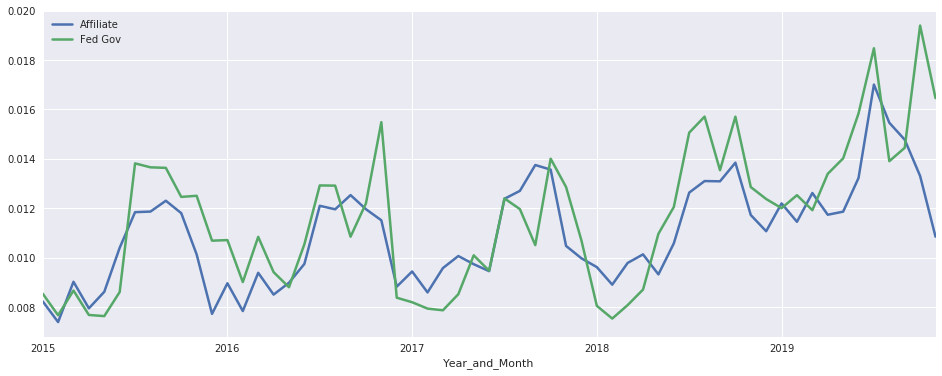

In [51]:
Channel.set_index('Year_and_Month')[['Affiliate','Fed Gov']].plot(figsize=(16, 6), linewidth=2.5)
plt.show()

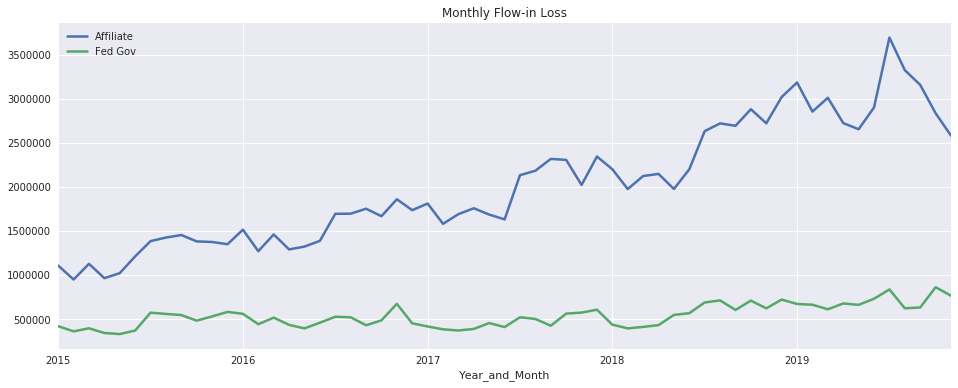

In [56]:
A.set_index('Year_and_Month')[['Affiliate','Fed Gov']].plot(title='Monthly Flow-in Loss',figsize=(16, 6), linewidth=2.5)
plt.show()

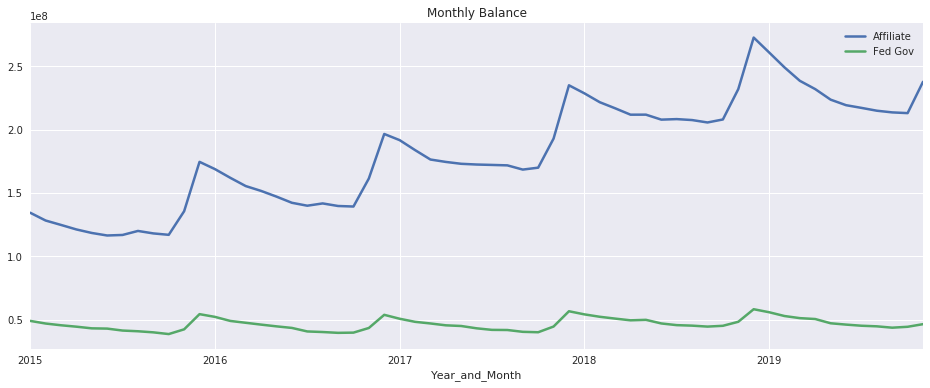

In [55]:
B.set_index('Year_and_Month')[['Affiliate','Fed Gov']].plot(title='Monthly Balance',figsize=(16, 6), linewidth=2.5)
plt.show()

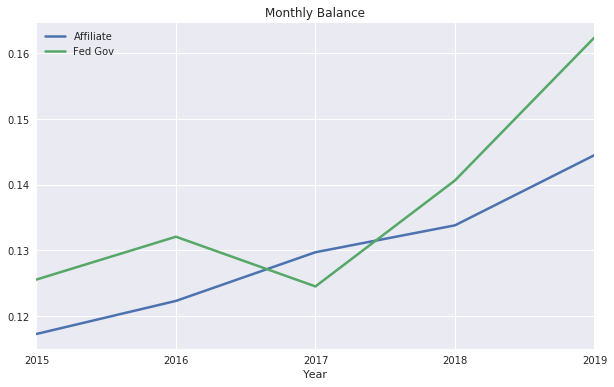

In [74]:
Channel.groupby(['Year']).agg({'Fed Gov':'sum','Affiliate':'sum'})[['Affiliate','Fed Gov']].plot(title='Monthly Balance',figsize=(10, 6), linewidth=2.5)
plt.show()

In [13]:
# Orders per Customer
Bad_Orders_p_cust = P15[(P15['Bad']==1)&(P15['Ever_Bad']==1)].groupby('Year').agg({'Unique_Customer_ID':'nunique','Unique_Order_ID':'nunique'}).reset_index()
Bad_Orders_p_cust['num_of_orders_per_cust'] = Bad_Orders_p_cust['Unique_Order_ID']/Bad_Orders_p_cust['Unique_Customer_ID']
Bad_Orders_p_cust['Year'] = pd.to_datetime(Bad_Orders_p_cust['Year'].astype(str),format='%Y')

In [35]:
Bad_Orders_p_cust

Year  Unique_Customer_ID  Unique_Order_ID  num_of_orders_per_cust
0 2015-01-01               19132            35978                1.880514
1 2016-01-01               22263            48784                2.191259
2 2017-01-01               26688            62995                2.360424
3 2018-01-01               31779            80360                2.528714
4 2019-01-01               33886            97880                2.888509

In [15]:
P15_good = P15.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0)
Good_Orders_p_cust = P15_good.groupby('Year').agg({'Unique_Customer_ID':'nunique','Unique_Order_ID':'nunique'}).reset_index()
Good_Orders_p_cust['num_of_orders_per_cust'] = Good_Orders_p_cust['Unique_Order_ID']/Good_Orders_p_cust['Unique_Customer_ID']
Good_Orders_p_cust['Year'] = pd.to_datetime(Good_Orders_p_cust['Year'].astype(str),format='%Y')

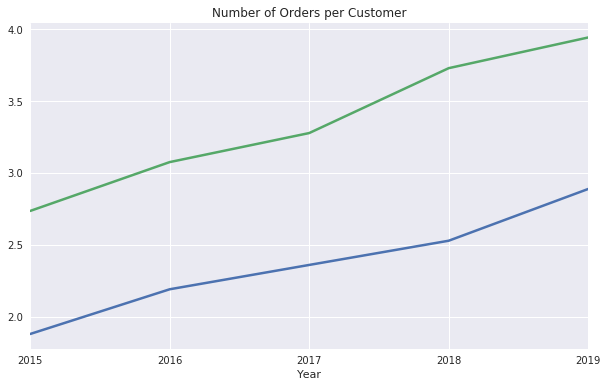

In [16]:
Bad_Orders_p_cust.set_index('Year')['num_of_orders_per_cust'].plot(title='Number of Orders per Customer',figsize=(10, 6), linewidth=2.5)
Good_Orders_p_cust.set_index('Year')['num_of_orders_per_cust'].plot(title='Number of Orders per Customer',figsize=(10, 6), linewidth=2.5)
plt.show()

In [ ]:
P15[P15['Year_and_Month']=='2015-01-01'].groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0).shape[0] + P15[([P15['Year_and_Month']=='2015-01-01'])&(P15['Bad']==1)&(P15['Ever_Bad']==1)].shape[0]

In [15]:
P15[P15['Year_and_Month']=='2015-01-01'].shape[0]

316919

In [ ]:
# Unit Loss Rate

In [11]:
A_unit = P15[(P15['Bad']==1)&(P15['Ever_Bad']==1)].pivot_table(values = 'Unique_Order_ID',index = 'Year_and_Month', columns='Affiliate/Fed Gov?',aggfunc='nunique' ).reset_index().rename_axis(None, axis=1)

In [12]:
B_unit = P15.pivot_table(values = 'Unique_Order_ID',index = 'Year_and_Month', columns='Affiliate/Fed Gov?',aggfunc='nunique' ).reset_index().rename_axis(None, axis=1)

In [16]:
Channel_unit = A_unit.iloc[:,1:]/B_unit.iloc[:,1:]
Channel_unit['Year_and_Month'] = A_unit['Year_and_Month']
Channel_unit['Year'] = Channel_unit['Year_and_Month'].dt.year
Channel_unit['Year'] = pd.to_datetime(Channel_unit['Year'].astype(str),format='%Y')
Channel_unit

Affiliate   Fed Gov Year_and_Month       Year
0    0.009877  0.009729     2015-01-01 2015-01-01
1    0.008995  0.008705     2015-02-01 2015-01-01
2    0.009951  0.008546     2015-03-01 2015-01-01
3    0.008936  0.007634     2015-04-01 2015-01-01
4    0.008506  0.007313     2015-05-01 2015-01-01
5    0.008577  0.007024     2015-06-01 2015-01-01
6    0.009369  0.009625     2015-07-01 2015-01-01
7    0.009971  0.008941     2015-08-01 2015-01-01
8    0.010331  0.009414     2015-09-01 2015-01-01
9    0.009889  0.008851     2015-10-01 2015-01-01
10   0.009586  0.009647     2015-11-01 2015-01-01
11   0.008509  0.011050     2015-12-01 2015-01-01
12   0.009867  0.010623     2016-01-01 2016-01-01
13   0.008730  0.008824     2016-02-01 2016-01-01
14   0.009568  0.008319     2016-03-01 2016-01-01
15   0.008453  0.009057     2016-04-01 2016-01-01
16   0.007951  0.008427     2016-05-01 2016-01-01
17   0.007782  0.008114     2016-06-01 2016-01-01
18   0.009024  0.008496     2016-07-01 2016-01-01
19   0.009866  0.008989     2016-08-01 2016-01-01
20   0.010711  0.008111     2016-09-01 2016-01-01
21   0.010342  0.008546     2016-10-01 2016-01-01
22   0.010439  0.012209     2016-11-01 2016-01-01
23   0.009295  0.007342     2016-12-01 2016-01-01
24   0.011163  0.007503     2017-01-01 2017-01-01
25   0.010185  0.008363     2017-02-01 2017-01-01
26   0.010140  0.007195     2017-03-01 2017-01-01
27   0.010761  0.007087     2017-04-01 2017-01-01
28   0.009717  0.009236     2017-05-01 2017-01-01
29   0.007907  0.006177     2017-06-01 2017-01-01
30   0.009822  0.007389     2017-07-01 2017-01-01
31   0.010815  0.007713     2017-08-01 2017-01-01
32   0.011523  0.007855     2017-09-01 2017-01-01
33   0.012027  0.009925     2017-10-01 2017-01-01
34   0.009588  0.010320     2017-11-01 2017-01-01
35   0.010254  0.009601     2017-12-01 2017-01-01
36   0.010537  0.008219     2018-01-01 2018-01-01
37   0.009513  0.008265     2018-02-01 2018-01-01
38   0.010220  0.008271     2018-03-01 2018-01-01
39   0.009896  0.008574     2018-04-01 2018-01-01
40   0.008509  0.011451     2018-05-01 2018-01-01
41   0.008243  0.008188     2018-06-01 2018-01-01
42   0.009990  0.010470     2018-07-01 2018-01-01
43   0.010816  0.010270     2018-08-01 2018-01-01
44   0.011305  0.010564     2018-09-01 2018-01-01
45   0.012369  0.013623     2018-10-01 2018-01-01
46   0.010802  0.010608     2018-11-01 2018-01-01
47   0.011481  0.010880     2018-12-01 2018-01-01
48   0.012678  0.011671     2019-01-01 2019-01-01
49   0.011653  0.012574     2019-02-01 2019-01-01
50   0.012734  0.011321     2019-03-01 2019-01-01
51   0.012263  0.011680     2019-04-01 2019-01-01
52   0.011001  0.011771     2019-05-01 2019-01-01
53   0.011522  0.010906     2019-06-01 2019-01-01
54   0.013766  0.012773     2019-07-01 2019-01-01
55   0.013230  0.010805     2019-08-01 2019-01-01
56   0.013007  0.011401     2019-09-01 2019-01-01
57   0.011945  0.016328     2019-10-01 2019-01-01
58   0.010754  0.013292     2019-11-01 2019-01-01

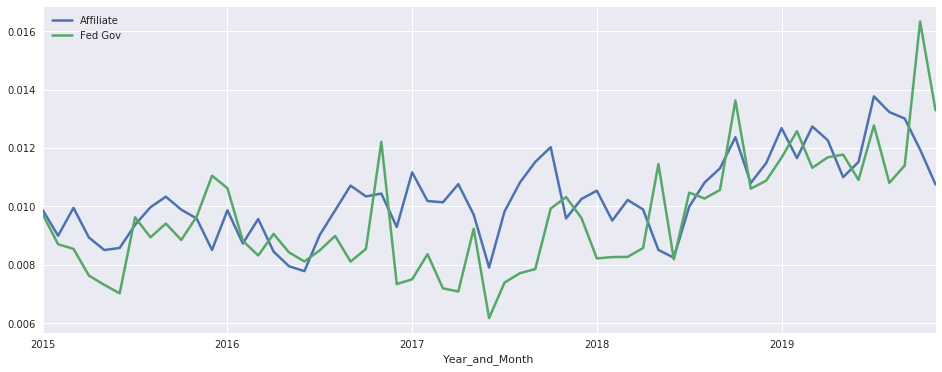

In [17]:
Channel_unit.set_index('Year_and_Month')[['Affiliate','Fed Gov']].plot(figsize=(16, 6), linewidth=2.5)
plt.show()

In [10]:
Old_2015 = Perf[(Perf['Year_and_Month']>='2014-12-01') & (Perf['Year_and_Month']<='2015-11-01')]
New_2019 = Perf[(Perf['Year_and_Month']>='2018-12-01') & (Perf['Year_and_Month']<='2019-11-01')]

In [11]:
Old_2015['Flag'] = 'Old'
New_2019['Flag'] = 'New'
df = Old_2015.append(New_2019,ignore_index = True)

In [41]:
# Loss rate by Channel
Old_lr = Old_2015[(Old_2015['Bad']==1) & (Old_2015['Ever_Bad']==1)]['2os_loss'].sum()/Old_2015['Current_Balance'].sum()*12
New_lr = New_2019[(New_2019['Bad']==1) & (New_2019['Ever_Bad']==1)]['2os_loss'].sum()/New_2019['Current_Balance'].sum()*12
print('2015 Loss Rate {}'.format(Old_lr))
print('2019 Loss Rate {}'.format(New_lr))

2015 Loss Rate 0.11300565278586913
2019 Loss Rate 0.15729958806109115


In [54]:
df[(df['Bad']==1)&(df['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Affiliate/Fed Gov?',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()

Affiliate/Fed Gov?          New          Old
0          Affiliate  35934490.75  14633864.49
1            Fed Gov   8448989.94   5418059.08

In [52]:
df.pivot_table(values = 'Current_Balance',index = 'Affiliate/Fed Gov?',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()

Affiliate/Fed Gov?           New           Old
0          Affiliate  2.793072e+09  1.490401e+09
1            Fed Gov  5.866059e+08  5.271890e+08

In [43]:
# Old_2015[(Old_2015['Bad']==1) & (Old_2015['Ever_Bad']==1)].groupby('Affiliate/Fed Gov?').agg({'2os_loss':'sum'})

2os_loss
Affiliate/Fed Gov?             
Affiliate           14633864.49
Fed Gov              5418059.08

In [63]:
# Loss rate by Industry
loss_Ind = df[(df['Bad']==1)&(df['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Industry',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()#.fillna(0)
# loss_Ind.rename(columns={'New'})

prefix = 'loss_'
new_names = [(i,prefix + i) for i in ['New','Old']]
loss_Ind.rename(columns = dict(new_names), inplace=True)
loss_Ind

Industry     loss_New    loss_Old
0                    Accommodation and Food Services   1884986.18   252588.87
1                         Administrative and Support    688263.07   229397.90
2                Arts, Entertainment, and Recreation     14519.90         NaN
3                                       Construction      7836.01         NaN
4                               Educational Services    456467.73   215692.45
5                    Federal Government/Associations   8448989.94  5418059.08
6                              Finance and Insurance   1140680.29   628858.93
7                  Health Care and Social Assistance  11059271.43  4158014.42
8                                        Information   3563246.22  1378838.90
9                      Local Government/Associations    797014.24   181906.19
10           Management of Companies and Enterprises    107879.50     5290.65
11                                     Manufacturing   3855554.89  1307021.45
12     Mining, Quarrying, and Oil and Gas Extraction      1248.49    92208.18
13           Nursing and Residential Care Facilities   1167625.56   954277.06
14     Other Services (except Public Administration)    621860.44   295328.16
15  Professional, Scientific, and Technical Services    637300.06   181054.13
16                Real Estate and Rental and Leasing     20596.79    20702.91
17                                      Retail Trade   4843285.95  2528694.17
18                     State Government/Associations   3182177.73  1626108.34
19                    Transportation and Warehousing   1074870.16   511707.08
20                                         Utilities      5130.20     7478.10
21                                   Wholesale Trade    810878.06    97673.79

In [62]:
bal_Ind = df.pivot_table(values = 'Current_Balance',index = 'Industry',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()#.fillna(0)

prefix = 'Balance_'
new_names = [(i,prefix + i) for i in ['New','Old']]
bal_Ind.rename(columns = dict(new_names), inplace=True)
bal_Ind

Industry   Balance_New   Balance_Old
0                    Accommodation and Food Services  1.275671e+08  1.720143e+07
1                         Administrative and Support  4.208072e+07  1.641455e+07
2                Arts, Entertainment, and Recreation  2.764343e+05           NaN
3                                       Construction  5.435360e+05           NaN
4                               Educational Services  6.650985e+07  1.929554e+07
5                                        Engineering  5.713768e+04  1.825912e+04
6                    Federal Government/Associations  5.866059e+08  5.271890e+08
7                              Finance and Insurance  9.397760e+07  5.502826e+07
8                  Health Care and Social Assistance  9.377450e+08  4.286868e+08
9                                         Healthcare  5.554429e+05           NaN
10                                       Information  1.702490e+08  1.386046e+08
11                     Local Government/Associations  8.858890e+07  2.898198e+07
12                                         Machinery  3.827341e+04           NaN
13           Management of Companies and Enterprises  7.671229e+06  2.493562e+05
14                                     Manufacturing  2.698433e+08  1.220994e+08
15     Mining, Quarrying, and Oil and Gas Extraction  7.762625e+05  4.412838e+06
16           Nursing and Residential Care Facilities  8.505518e+07  7.413543e+07
17     Other Services (except Public Administration)  4.471422e+07  5.387714e+07
18  Professional, Scientific, and Technical Services  4.021132e+07  1.213512e+07
19                Real Estate and Rental and Leasing  1.087191e+06  1.654978e+06
20                                            Retail  7.325184e+04           NaN
21                          Retail & Wholesale Trade  1.103328e+05           NaN
22                                      Retail Trade  3.549607e+08  2.268014e+08
23                     State Government/Associations  3.111288e+08  2.321441e+08
24                    Transportation and Warehousing  1.045316e+08  7.118683e+07
25                                         Utilities  1.049598e+06  7.276528e+05
26                                   Wholesale Trade  4.653468e+07  9.005215e+06

In [64]:
Ind = bal_Ind.merge(loss_Ind, how='left',on='Industry')#.fillna(0)
Ind

Industry   Balance_New   Balance_Old     loss_New    loss_Old
0                    Accommodation and Food Services  1.275671e+08  1.720143e+07   1884986.18   252588.87
1                         Administrative and Support  4.208072e+07  1.641455e+07    688263.07   229397.90
2                Arts, Entertainment, and Recreation  2.764343e+05           NaN     14519.90         NaN
3                                       Construction  5.435360e+05           NaN      7836.01         NaN
4                               Educational Services  6.650985e+07  1.929554e+07    456467.73   215692.45
5                                        Engineering  5.713768e+04  1.825912e+04          NaN         NaN
6                    Federal Government/Associations  5.866059e+08  5.271890e+08   8448989.94  5418059.08
7                              Finance and Insurance  9.397760e+07  5.502826e+07   1140680.29   628858.93
8                  Health Care and Social Assistance  9.377450e+08  4.286868e+08  11059271.43  4158014.42
9                                         Healthcare  5.554429e+05           NaN          NaN         NaN
10                                       Information  1.702490e+08  1.386046e+08   3563246.22  1378838.90
11                     Local Government/Associations  8.858890e+07  2.898198e+07    797014.24   181906.19
12                                         Machinery  3.827341e+04           NaN          NaN         NaN
13           Management of Companies and Enterprises  7.671229e+06  2.493562e+05    107879.50     5290.65
14                                     Manufacturing  2.698433e+08  1.220994e+08   3855554.89  1307021.45
15     Mining, Quarrying, and Oil and Gas Extraction  7.762625e+05  4.412838e+06      1248.49    92208.18
16           Nursing and Residential Care Facilities  8.505518e+07  7.413543e+07   1167625.56   954277.06
17     Other Services (except Public Administration)  4.471422e+07  5.387714e+07    621860.44   295328.16
18  Professional, Scientific, and Technical Services  4.021132e+07  1.213512e+07    637300.06   181054.13
19                Real Estate and Rental and Leasing  1.087191e+06  1.654978e+06     20596.79    20702.91
20                                            Retail  7.325184e+04           NaN          NaN         NaN
21                          Retail & Wholesale Trade  1.103328e+05           NaN          NaN         NaN
22                                      Retail Trade  3.549607e+08  2.268014e+08   4843285.95  2528694.17
23                     State Government/Associations  3.111288e+08  2.321441e+08   3182177.73  1626108.34
24                    Transportation and Warehousing  1.045316e+08  7.118683e+07   1074870.16   511707.08
25                                         Utilities  1.049598e+06  7.276528e+05      5130.20     7478.10
26                                   Wholesale Trade  4.653468e+07  9.005215e+06    810878.06    97673.79

In [18]:
df_act = df[df['Active']=='Y']

In [19]:
# Loss rate by Client
loss_Cli = df_act[(df_act['Bad']==1)&(df_act['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Account Name',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index().fillna(0)
prefix = 'loss_'
new_names = [(i,prefix + i) for i in ['New','Old']]
loss_Cli.rename(columns = dict(new_names), inplace=True)

bal_Cli = df_act.pivot_table(values = 'Current_Balance',index = 'Account Name',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()
prefix = 'Balance_'
new_names = [(i,prefix + i) for i in ['New','Old']]
bal_Cli.rename(columns = dict(new_names), inplace=True)


In [20]:
Cli = bal_Cli.merge(loss_Cli, how='left',on='Account Name').fillna(0)
Cli.to_csv('../data/Cli.csv',index = False)
Cli

Account Name   Balance_New   Balance_Old    loss_New    loss_Old
0                                       7-ELEVEN, INC.  1.253553e+05  5.667191e+05     3678.88     7756.68
1                                         ADTRAN, INC.  3.107609e+05  0.000000e+00        0.00        0.00
2                             ADVANCE AUTO PARTS, INC.  3.449564e+07  2.104372e+07   598821.72   259507.97
3                                                AECOM  8.146848e+06  4.089357e+06   121018.58    64085.14
4                                                 AFNI  1.318722e+06  1.543764e+06    23605.09    32417.95
5                  ALABAMA STATE EMPLOYEES ASSOCIATION  6.616936e+06  6.495919e+06    54252.45    46035.00
6                           ALLINA HOSPITALS & CLINICS  8.433181e+06  7.210633e+06   114680.40    59443.93
7                                     ALPHASTAFF, INC.  1.849675e+06  1.238750e+06    52454.26    20796.22
8          AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES  5.950113e+07  7.073871e+07   581497.87   590660.49
9                                   AMERICAN RED CROSS  1.962418e+07  1.603416e+07   224478.18   176283.20
10                                       APL LOGISTICS  1.160584e+06  5.835048e+05    19459.65     1476.64
11              APPALACHIAN REGIONAL HEALTHCARE SYSTEM  1.183425e+06  7.077605e+05     2518.55     1162.66
12                                                APWU  4.867652e+06  6.428200e+03    12402.78        0.00
13          ARKANSAS STATE EMPLOYEES ASSOCIATION (ACH)  3.289403e+06  1.304793e+07    64202.90     3375.77
14                             ARTHUR J GALLAGHER & CO  4.537948e+06  3.698505e+06    51963.75    29630.46
15                                        ASPEN DENTAL  3.348319e+06  1.452144e+06    53009.79    12300.70
16                  ASSOCIATED WHOLESALE GROCERS, INC.  2.525998e+06  0.000000e+00    36288.33        0.00
17                                  ATHENA HEALTH CARE  5.955271e+05  0.000000e+00     1984.66        0.00
18                           ATLANTIC GENERAL HOSPITAL  3.325503e+05  4.435170e+05     3931.32     5527.94
19                       AUGEO AFFINITY MARKETING, INC  1.488414e+04  4.765178e+04     1123.23      540.92
20                                         AUTOLIV ASP  2.484644e+06  0.000000e+00    22237.08        0.00
21                              AUTOPART INTERNATIONAL  3.100203e+05  3.654163e+05     4666.79     5507.03
22                                      AVERY DENNISON  2.409300e+06  1.639656e+06    13888.50    31500.88
23                           American Medical Response  9.115135e+05  0.000000e+00        0.00        0.00
24                                       BALLAD HEALTH  6.875772e+06  4.535365e+06    58763.78    34678.50
25                                       BANNER HEALTH  3.091805e+07  1.976444e+07   372032.53   182881.63
26                           BAPTIST HEALTH (KENTUCKY)  1.045808e+07  1.307742e+06   112873.83      113.68
27                   BAPTIST MEMORIAL HEALTH CARE CORP  1.543788e+07  7.484837e+06   145548.59    75948.39
28                              BAY CARE HEALTH SYSTEM  3.187358e+07  1.696659e+07   405783.02   152732.13
29                         BAYLOR SCOTT & WHITE HEALTH  1.675609e+07  4.038154e+04    88400.57        0.00
30                                       BEACON HEALTH  4.422663e+06  4.368265e+06    53864.34    51327.41
31                                        BEALL'S INC.  2.321142e+06  1.257712e+06    27972.00    21218.22
32                               BETHESDA HEALTH GROUP  1.139103e+06  0.000000e+00    12794.31        0.00
33                                 BIBB COUNTY SCHOOLS  3.844840e+06  2.391588e+06    19924.60    38413.23
34                                         BIG Y FOODS  2.234300e+06  1.345608e+06    13339.70     6494.80
35                                   BLUE SHIELD OF CA  6.220122e+06  5.876074e+06    90934.85    83945.00
36   BOARD OF REGENTS OF THE UNIVERSITY SYSTEM OF G...  9.257934e+06  8.843030e+03 

In [ ]:
df[var+'_bin'] = pd.qcut(df[var], q=4)
df.groupby(var+'_bin')['Bad'].sum().div(df.groupby(var+'_bin')['Unique_Customer_ID'].size())

In [ ]:
'Customer_Salary','Customer_Tenure'

In [21]:
Customer.head()

Unique_Customer_ID  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary Prior_Customer_Flag                 Street1 Street2           City State    Zip    Status Term_Date Active  Client ID                    Account Name  Current Eligibles  Eligibles at time of Launch                         Industry  NAICS Code                                  NAICS Description Broker Launch Date Termination Date Affiliate/Fed Gov? CLIENT CODE                     CLIENT NAME         CLIENT AR                                Cash  TPA
0           100001115               1000      2014-02-24                   6880.0            230.0          58229.0        Repeat Buyer          1471 N EAST ST     NaN           YORK    PA  17406  EMPLOYED       NaT      Y     1000.0  SOCIAL SECURITY ADMINISTRATION            60000.0                      70000.0  Federal Government/Associations    923130.0  Administration of Social, Human Resource and I...    PPC  2002-07-01              NaT            Fed Gov         SSA  SOCIAL SECURITY ADMINISTRATION  KELLY MENCHINGER  TPA sends cash on behalf of client  EAA
1           100001120               1000      2014-02-24                   6520.0            362.0         109245.0        Repeat Buyer         94 BRENTWOOD LN     NaN  VALLEY STREAM    NY  11581  EMPLOYED       NaT      Y     1000.0  SOCIAL SECURITY ADMINISTRATION            60000.0                      70000.0  Federal Government/Associations    923130.0  Administration of Social, Human Resource and I...    PPC  2002-07-01              NaT            Fed Gov         SSA  SOCIAL SECURITY ADMINISTRATION  KELLY MENCHINGER  TPA sends cash on behalf of client  EAA
2           100001141               1000      2014-02-25                  10290.0            337.0         127226.0        Repeat Buyer  103 KENILWORTH PARK DR  APT 2B         TOWSON    MD  21204  EMPLOYED       NaT      Y     1000.0  SOCIAL SECURITY ADMINISTRATION            60000.0                      70000.0  Federal Government/Associations    923130.0  Administration of Social, Human Resource and I...    PPC  2002-07-01              NaT            Fed Gov         SSA  SOCIAL SECURITY ADMINISTRATION  KELLY MENCHINGER  TPA sends cash on behalf of client  EAA
3           100001158               1000      2014-02-24                   5190.0            419.0          49375.0        Repeat Buyer       1036 BRADDISH AVE     NaN      BALTIMORE    MD  21216  EMPLOYED       NaT      Y     1000.0  SOCIAL SECURITY ADMINISTRATION            60000.0                      70000.0  Federal Government/Associations    923130.0  Administration of Social, Human Resource and I...    PPC  2002-07-01              NaT            Fed Gov         SSA  SOCIAL SECURITY ADMINISTRATION  KELLY MENCHINGER  TPA sends cash on behalf of client  EAA
4           100001169               1000      2014-02-24                   7500.0            448.0          69460.0        Repeat Buyer       3915 W ROGERS AVE     NaN      BALTIMORE    MD  21215  EMPLOYED       NaT      Y     1000.0  SOCIAL SECURITY ADMINISTRATION            60000.0                      70000.0  Federal Government/Associations    923130.0  Administration of Social, Human Resource and I...    PPC  2002-07-01              NaT            Fed Gov         SSA  SOCIAL SECURITY ADMINISTRATION  KELLY MENCHINGER  TPA sends cash on behalf of client  EAA

In [27]:
def Perf_filter(df):
    """
    This function takes the Perf dataset and subgroup is with time window condition, 
    then it generates some of the customer-level variables that we expect, such as
    Num_of_Contracts,Total_CO_Balance,Total_Spend
    
    The output would be a customer-level dataframe, where the customers are enrolled in 2017-04 to 2018-04 time period
    """
    
    
    # Get the latest order records
    df = df.loc[df.groupby('Unique_Order_ID')[
        'Year_and_Month'].idxmax()]
    # create customer level data with "# of orders" and "Bad Flag"
    df = df.groupby('Unique_Customer_ID').agg(
        {'Unique_Order_ID': 'count', 'Ever_Bad': 'sum', '2os_loss': 'sum', 'Order_Amount': 'sum','Customer_Salary':'unique','Customer_Tenure':'unique'}).reset_index()
    # The definition of Bad here is whether a customer has at least 1 order goes bad
    df['Bad'] = df['Ever_Bad'] >= 1

    df.rename(columns={'Unique_Order_ID': 'Num_of_Contracts',
                           '2os_loss': 'Total_CO_Balance', 'Order_Amount': 'Total_Spend'}, inplace=True)

    return df

In [12]:
Old_2015 = Perf[(Perf['Year_and_Month']>='2014-12-01') & (Perf['Year_and_Month']<='2015-11-01')]
New_2019 = Perf[(Perf['Year_and_Month']>='2018-12-01') & (Perf['Year_and_Month']<='2019-11-01')]

In [13]:
df_2015 = Perf_filter(Old_2015)
df_2019 = Perf_filter(New_2019)

NameError: name 'Perf_filter' is not defined

In [120]:
var = 'Customer_Salary'
cut_labels = ['[0-30000]', '[30000-40000]', '[40000-50000]', '[50000-70000]','[70000+]']
cut_bins = [0,30000, 40000, 50000, 70000,np.inf]
Old_2015[var+'_bin'] = pd.cut(Old_2015[var], bins=cut_bins, labels=cut_labels)

In [121]:
Old_2015.groupby('Customer_Salary_bin').agg({'Current_Balance':'sum'})

Current_Balance
Customer_Salary_bin                 
[0-30000]               2.539928e+08
[30000-40000]           3.728829e+08
[40000-50000]           3.637533e+08
[50000-70000]           4.742459e+08
[70000+]                4.049877e+08

In [123]:
Old_2015[(Old_2015['Bad']==1)&(Old_2015['Ever_Bad']==1)].groupby('Customer_Salary_bin').agg({'2os_loss':'sum'})

2os_loss
Customer_Salary_bin            
[0-30000]            5543467.07
[30000-40000]        5180025.24
[40000-50000]        3165571.79
[50000-70000]        3502406.68
[70000+]             1772525.53

In [122]:
New_2019[var+'_bin'] = pd.cut(New_2019[var], bins=cut_bins, labels=cut_labels)
New_2019.groupby('Customer_Salary_bin').agg({'Current_Balance':'sum'})

Current_Balance
Customer_Salary_bin                 
[0-30000]               3.828590e+08
[30000-40000]           8.947077e+08
[40000-50000]           7.211130e+08
[50000-70000]           7.574033e+08
[70000+]                5.619169e+08

In [124]:
New_2019[(New_2019['Bad']==1)&(New_2019['Ever_Bad']==1)].groupby('Customer_Salary_bin').agg({'2os_loss':'sum'})

2os_loss
Customer_Salary_bin             
[0-30000]             8107168.94
[30000-40000]        15008228.50
[40000-50000]         8730906.12
[50000-70000]         8082531.34
[70000+]              3840495.69

In [33]:
df_2015.head()

Unique_Customer_ID  Num_of_Contracts  Ever_Bad  Total_CO_Balance  Total_Spend  Customer_Salary  Customer_Tenure    Bad
0           100001115                 1         2            658.76       691.12          58229.0            230.0   True
1           100001120                 9         0              0.00     20441.43         109245.0            362.0  False
2           100001141                 1         0              0.00      2929.90         127226.0            337.0  False
3           100001158                 2        11           1167.15      2603.95          49375.0            419.0   True
4           100001169                 1         0              0.00       943.18          69460.0            448.0  False

In [32]:
df_2015['Customer_Salary'] = df_2015['Customer_Salary'].apply(lambda x:x[0])
df_2015['Customer_Tenure'] = df_2015['Customer_Tenure'].apply(lambda x:x[0])
df_2019['Customer_Salary'] = df_2019['Customer_Salary'].apply(lambda x:x[0])
df_2019['Customer_Tenure'] = df_2019['Customer_Tenure'].apply(lambda x:x[0])

In [38]:
df_2015['Customer_Salary'].describe()

count    1.934760e+05
mean     4.857720e+04
std      1.146223e+05
min      0.000000e+00
25%      3.120000e+04
50%      4.218000e+04
75%      5.847835e+04
max      2.610239e+07
Name: Customer_Salary, dtype: float64

In [57]:
cut_labels = ['[0-30000]', '[30000-40000]', '[40000-50000]', '[50000-70000]','[70000+]']
cut_bins = [0,30000, 40000, 50000, 70000,np.inf]
df_2015[var+'_bin'] = pd.cut(df_2015[var], bins=cut_bins, labels=cut_labels)

In [58]:
df_2015.head()

Unique_Customer_ID  Num_of_Contracts  Ever_Bad  Total_CO_Balance  Total_Spend  Customer_Salary  Customer_Tenure    Bad Customer_Salary_bin
0           100001115                 1         2            658.76       691.12          58229.0            230.0   True       [50000-70000]
1           100001120                 9         0              0.00     20441.43         109245.0            362.0  False            [70000+]
2           100001141                 1         0              0.00      2929.90         127226.0            337.0  False            [70000+]
3           100001158                 2        11           1167.15      2603.95          49375.0            419.0   True       [40000-50000]
4           100001169                 1         0              0.00       943.18          69460.0            448.0  False       [50000-70000]

In [59]:
df_2015.groupby(var+'_bin')['Bad'].sum().div(df_2015.groupby(var+'_bin')['Unique_Customer_ID'].size())

Customer_Salary_bin
[0-30000]        0.206039
[30000-40000]    0.123328
[40000-50000]    0.085087
[50000-70000]    0.070444
[70000+]         0.045433
dtype: float64

In [60]:
df_2015.groupby(var+'_bin')['Unique_Customer_ID'].size()

Customer_Salary_bin
[0-30000]        43249
[30000-40000]    44783
[40000-50000]    35693
[50000-70000]    40259
[70000+]         29208
Name: Unique_Customer_ID, dtype: int64

In [62]:
df_2019[var+'_bin'] = pd.cut(df_2019[var], bins=cut_bins, labels=cut_labels)
df_2019.groupby(var+'_bin')['Bad'].sum().div(df_2019.groupby(var+'_bin')['Unique_Customer_ID'].size())

Customer_Salary_bin
[0-30000]        0.242111
[30000-40000]    0.163648
[40000-50000]    0.116096
[50000-70000]    0.099500
[70000+]         0.066240
dtype: float64

In [63]:
df_2019.groupby(var+'_bin')['Unique_Customer_ID'].size()

Customer_Salary_bin
[0-30000]        67754
[30000-40000]    97545
[40000-50000]    61182
[50000-70000]    57849
[70000+]         37847
Name: Unique_Customer_ID, dtype: int64

In [64]:
# Tenure
df_2015['Customer_Tenure'].describe()

count    229524.000000
mean        159.078489
std          89.743338
min         -12.000000
25%          92.000000
50%         137.000000
75%         201.000000
max        1605.000000
Name: Customer_Tenure, dtype: float64

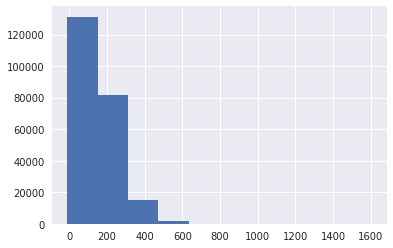

In [66]:
df_2015['Customer_Tenure'].hist(bins=10)

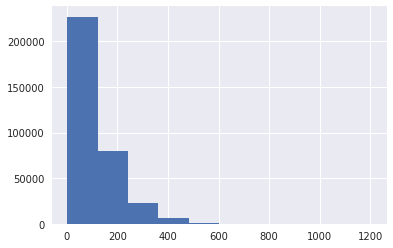

In [67]:
df_2019['Customer_Tenure'].hist(bins=10)

In [136]:
var='Customer_Tenure'
tenure_cut_labels = ['[0-50]','[50-100]', '[100-150]', '[150-200]', '[200-300]','[300+]']
tenure_cut_bins = [0,50,100,150, 200, 300,np.inf]
df_2015[var+'_bin'] = pd.cut(df_2015[var], bins=tenure_cut_bins, labels=tenure_cut_labels)
df_2015.groupby('Customer_Tenure_bin').size()

Customer_Tenure_bin
[0-50]        2118
[50-100]     69205
[100-150]    61243
[150-200]    39500
[200-300]    38725
[300+]       18732
dtype: int64

In [137]:
df_2019[var+'_bin'] = pd.cut(df_2019[var], bins=tenure_cut_bins, labels=tenure_cut_labels)
df_2019.groupby('Customer_Tenure_bin').size()

Customer_Tenure_bin
[0-50]       111789
[50-100]      95096
[100-150]     47903
[150-200]     33707
[200-300]     33686
[300+]        14461
dtype: int64

In [138]:
var='Customer_Tenure'
tenure_cut_labels = ['[0-50]','[50-100]', '[100-150]', '[150-200]', '[200-300]','[300+]']
tenure_cut_bins = [0,50,100,150, 200, 300,np.inf]
Old_2015[var+'_bin'] = pd.cut(Old_2015[var], bins=tenure_cut_bins, labels=tenure_cut_labels)
Old_2015.groupby('Customer_Tenure_bin').agg({'Current_Balance':'sum'})

Current_Balance
Customer_Tenure_bin                 
[0-50]                  1.768925e+07
[50-100]                5.040637e+08
[100-150]               5.820938e+08
[150-200]               4.059568e+08
[200-300]               4.244169e+08
[300+]                  2.126137e+08

In [139]:
Old_2015[(Old_2015['Bad']==1)&(Old_2015['Ever_Bad']==1)].groupby('Customer_Tenure_bin').agg({'2os_loss':'sum'})

2os_loss
Customer_Tenure_bin            
[0-50]                180966.57
[50-100]             6566482.34
[100-150]            6497213.28
[150-200]            3221683.86
[200-300]            2675648.92
[300+]               1075890.25

In [140]:
New_2019[var+'_bin'] = pd.cut(New_2019[var], bins=tenure_cut_bins, labels=tenure_cut_labels)
New_2019.groupby('Customer_Tenure_bin').agg({'Current_Balance':'sum'})

Current_Balance
Customer_Tenure_bin                 
[0-50]                  8.793964e+08
[50-100]                9.795954e+08
[100-150]               5.520907e+08
[150-200]               4.020767e+08
[200-300]               4.062045e+08
[300+]                  1.702520e+08

In [141]:
New_2019[(New_2019['Bad']==1)&(New_2019['Ever_Bad']==1)].groupby('Customer_Tenure_bin').agg({'2os_loss':'sum'})

2os_loss
Customer_Tenure_bin             
[0-50]               16131531.12
[50-100]             15109857.83
[100-150]             5875263.22
[150-200]             3295217.62
[200-300]             2753509.79
[300+]                1265676.90

In [142]:
180966.57/1.768925e+07

0.010230313325890018

In [143]:
6566482.34/5.040637e+08

0.01302708832236878

In [144]:
16131531.12/8.793964e+08

0.018343867589178213

In [145]:
15109857.83/9.795954e+08

0.015424590427843986

In [80]:
df_2015.groupby(var+'_bin')['Bad'].sum().div(df_2015.groupby(var+'_bin')['Unique_Customer_ID'].size())

Customer_Tenure_bin
[0-100]      0.115615
[100-150]    0.120422
[150-200]    0.087924
[200-300]    0.070187
[300+]       0.060858
dtype: float64

In [77]:
df_2015.groupby(var+'_bin')['Unique_Customer_ID'].size()

Customer_Tenure_bin
[0-50]       71323
[100-150]    61243
[150-200]    39500
[200-300]    38725
[300+]       18732
Name: Unique_Customer_ID, dtype: int64

In [83]:
df_2019[var+'_bin'] = pd.cut(df_2019[var], bins=tenure_cut_bins, labels=tenure_cut_labels)
df_2019.groupby(var+'_bin')['Bad'].sum().div(df_2019.groupby(var+'_bin')['Unique_Customer_ID'].size())

Customer_Tenure_bin
[0-100]      0.176344
[100-150]    0.119283
[150-200]    0.093957
[200-300]    0.075105
[300+]       0.077242
dtype: float64

In [84]:
df_2019.groupby(var+'_bin')['Unique_Customer_ID'].size()

Customer_Tenure_bin
[0-100]      206885
[100-150]     47903
[150-200]     33707
[200-300]     33686
[300+]        14461
Name: Unique_Customer_ID, dtype: int64

In [85]:
df_2015['Flag'] = 'Old'
df_2019['Flag'] = 'New'
df_cust = df_2015.append(df_2019,ignore_index = True)

In [86]:
df_cust.head()

Unique_Customer_ID  Num_of_Contracts  Ever_Bad  Total_CO_Balance  Total_Spend  Customer_Salary  Customer_Tenure    Bad Customer_Salary_bin Customer_Tenure_bin Flag
0           100001115                 1         2            658.76       691.12          58229.0            230.0   True       [50000-70000]           [200-300]  Old
1           100001120                 9         0              0.00     20441.43         109245.0            362.0  False            [70000+]              [300+]  Old
2           100001141                 1         0              0.00      2929.90         127226.0            337.0  False            [70000+]              [300+]  Old
3           100001158                 2        11           1167.15      2603.95          49375.0            419.0   True       [40000-50000]              [300+]  Old
4           100001169                 1         0              0.00       943.18          69460.0            448.0  False       [50000-70000]              [300+]  Old

In [135]:
df_cust['Customer_Tenure_bin'].value_counts(dropna=False)

[0-100]      278208
[100-150]    109146
[150-200]     73207
[200-300]     72411
[300+]        33193
NaN              67
Name: Customer_Tenure_bin, dtype: int64

In [96]:
df_cust[df_cust['Customer_Salary_bin'].isnull()]

Unique_Customer_ID  Num_of_Contracts  Ever_Bad  Total_CO_Balance  Total_Spend  Customer_Salary  Customer_Tenure    Bad Customer_Salary_bin Customer_Tenure_bin Flag
10               100001216                 2         5           3916.97      8109.75              NaN            353.0   True                 NaN              [300+]  Old
30               100003338                 1         0              0.00      1348.89              NaN            613.0  False                 NaN              [300+]  Old
42               100003572                 1         0              0.00      4996.96              NaN            290.0  False                 NaN           [200-300]  Old
44               100003591                 1         0              0.00       620.93              NaN            541.0  False                 NaN              [300+]  Old
118              100008296                 4        58              0.00      6071.95              NaN            480.0   True                 NaN              [300+]  Old
119              100008309                 2         0              0.00      2342.47              NaN            223.0  False                 NaN           [200-300]  Old
148              100008882                 8         0              0.00      6807.05              NaN            508.0  False                 NaN              [300+]  Old
149              100008884                 5        35           1483.70      6968.42              NaN            449.0   True                 NaN              [300+]  Old
168              100011996                 1         0              0.00      2790.55              NaN            224.0  False                 NaN           [200-300]  Old
174              100013354                 9         0              0.00     13064.43              NaN            373.0  False                 NaN              [300+]  Old
180              100016399                 3         0              0.00      1634.84              NaN             99.0  False                 NaN             [0-100]  Old
183              100016902                 1         0              0.00       875.86              NaN            368.0  False                 NaN              [300+]  Old
200              100019203                 2         0              0.00      2035.57              NaN             31.0  False                 NaN             [0-100]  Old
232              100025506                 3         0              0.00      4252.21              NaN            505.0  False                 NaN              [300+]  Old
235              100025583                 4         0              0.00      7336.23              NaN            468.0  False                 NaN              [300+]  Old
239              100025938                 5         0              0.00      9128.85              NaN            270.0  False                 NaN           [200-300]  Old
255              100027367                 5         0              0.00      8860.77              NaN            471.0  False                 NaN              [300+]  Old
295              100030640                 2         1            447.65      1582.40              NaN            226.0   True                 NaN           [200-300]  Old
299              100030757                 1         0              0.00      2789.82              NaN            254.0  False                 NaN           [200-300]  Old
305              100030888                 2         0              0.00      2429.30              NaN            412.0  False                 NaN              [300+]  Old
314              100031373                 6        18           2033.36      7723.99              NaN            291.0   True                 NaN           [200-300]  Old
324              100031696                 4         0              0.00      6985.61              NaN            279.0  False                 NaN           [200-300]  Old
327              100031838                 1        

In [104]:
df_cust[df_cust['Customer_Salary_bin'].notnull()].pivot_table(index='Customer_Salary_bin', values=
                    ['Total_CO_Balance','Total_Spend'], columns='Flag', aggfunc='sum')  # .reset_index()

Total_CO_Balance               Total_Spend              
Flag                             New         Old           New           Old
Customer_Salary_bin                                                         
[0-30000]                10541381.20  6202080.61  1.168834e+08  7.215053e+07
[30000-40000]            18653021.34  5828292.94  2.715251e+08  1.080915e+08
[40000-50000]            10748157.11  3623792.59  2.230013e+08  1.064902e+08
[50000-70000]             9752073.24  3981159.96  2.386574e+08  1.403800e+08
[70000+]                  4620304.07  2018301.45  1.813145e+08  1.225013e+08

In [106]:
df_cust[df_cust['Customer_Salary_bin'].notnull()].pivot_table(index='Customer_Salary_bin', values=
                    'Unique_Customer_ID', columns='Flag', aggfunc='nunique')  # .reset_index()

Flag                   New    Old
Customer_Salary_bin              
[0-30000]            67754  43249
[30000-40000]        97545  44783
[40000-50000]        61182  35693
[50000-70000]        57849  40259
[70000+]             37847  29208

In [107]:
df_cust[df_cust['Customer_Tenure_bin'].notnull()].pivot_table(index='Customer_Tenure_bin', values=
                    ['Total_CO_Balance','Total_Spend'], columns='Flag', aggfunc='sum')  # .reset_index()

Total_CO_Balance               Total_Spend              
Flag                             New         Old           New           Old
Customer_Tenure_bin                                                         
[0-100]                  38241257.28  7256936.82  5.632949e+08  1.425728e+08
[100-150]                 7527824.58  7446807.02  1.770464e+08  1.728487e+08
[150-200]                 4268450.69  3701912.72  1.300171e+08  1.221476e+08
[200-300]                 3524689.68  3061671.36  1.324575e+08  1.276880e+08
[300+]                    1522649.63  1233259.73  5.538212e+07  6.454704e+07

In [108]:
df_cust[df_cust['Customer_Tenure_bin'].notnull()].pivot_table(index='Customer_Tenure_bin', values=
                    'Unique_Customer_ID', columns='Flag', aggfunc='nunique')  # .reset_index()

Flag                    New    Old
Customer_Tenure_bin               
[0-100]              206885  71323
[100-150]             47903  61243
[150-200]             33707  39500
[200-300]             33686  38725
[300+]                14461  18732

In [112]:
df[['State_x','State_y']].head()

State_x State_y
0      CA      CA
1      CA      CA
2      CA      CA
3      CA      CA
4      CA      CA

In [117]:
sum(df['State_x']==df['State_y'])/df.shape[0]

0.9691959340485933

In [118]:
df[(df['State_x']!=df['State_y'])&(df['Bad']==1)&(df['Ever_Bad']==1)].shape[0]

4116

In [119]:
4116/394321

0.010438196291853592

In [116]:
df[df['State_x']!=df['State_y']][['State_x','State_y']]

State_x State_y
42            MA      VT
43            MA      VT
44            MA      VT
45            MA      VT
68            FL      NY
71            AL      MA
97            CA      FL
98            CA      FL
176           IA      IL
177           IA      IL
178           IA      IL
179           IA      IL
180           IA      IL
181           IA      IL
182           IA      IL
183           IA      IL
184           IA      IL
185           IA      IL
186           IA      IL
187           IA      IL
193           TN      VA
194           GA      IL
195           GA      IL
196           GA      IL
197           GA      IL
198           GA      IL
269           PA      MA
270           PA      MA
271           PA      MA
303           WA      MA
405           OH      AL
406           OH      AL
407           OH      AL
408           OH      AL
666           NC      VA
699           AL      GA
700           AL      GA
701           AL      GA
702           AL      GA
855           GA      AL
856           GA      AL
857           GA      AL
858           GA      AL
859           GA      AL
957           AL      VA
958           AL      VA
959           AL      VA
960           AL      VA
1091          GA      AL
1092          GA      AL
1093          GA      AL
1333          AL      FL
1334          AL      FL
1335          AL      FL
1666          FL      SC
1667          FL      SC
1668          FL      SC
1705          AL      FL
1706          FL      GA
1707          FL      GA
1708          FL      GA
1804          SC      FL
1805          SC      FL
2187          FL      IL
2188          FL      IL
2189          FL      IL
2216          FL      SC
2217          FL      SC
2571          MS      FL
2572          MS      FL
2573          MS      FL
2574          MS      FL
2629          MS      GA
2631          MS      GA
2632          MS      GA
2743          FL      GA
2744          FL      GA
2745          FL      GA
3184          FL      GA
3185          FL      GA
3186          FL      GA
3187          FL      GA
3239          GA      FL
3302          WV      AL
3619          FL      GA
3620          FL      GA
3621          FL      GA
3622          FL      GA
3623          FL      GA
3624          FL      GA
3649          AL      GA
3650          AL      GA
3671          PA      GA
3727          CA      GA
3808          AL      GA
3809          AL      GA
3810          AL      GA
3845          GA      AL
3904          NJ      GA
3936          NC      MD
3937          NC      MD
4172          MO      GA
4208          GA      OH
4455          PA      GA
4456          PA      GA
4457          PA      GA
4458          PA      GA
4500          GA      NY
4501          GA      NY
4502          GA      NY
4617          MI      GA
4618          MI      GA
4619          MI      GA
4620          MI      GA
4621          MI      GA
4664          FL      GA
4665          FL      GA
4666          FL      GA
4913          UT      GA
4914          UT      GA
4915          UT      GA
4916          UT      GA
4917          UT      GA
4918          UT      GA
4919          UT      GA
4920          UT      GA
4921          UT      GA
4922          UT      GA
4923          UT      GA
4924          UT      GA
5178          WI      PA
5359          ME      NH
5385          CA      MN
5386          CA      MN
5387          CA      MN
5456          NY      NC
5457          NY      NC
5458          NY      NC
5769          NJ      GA
5893          NY      NJ
6001          IL      NV
6018          AZ      NV
6268          CA      NV
6269          CA      NV
6297          CA      NV
6300          PA      NJ
6453          TX      NV
6496          CA      NV
6629          CO      NV
6634          CA      NV
6635          CA      NV
6636          CA      NV
6816          CA      NV
6817          CA      NV
6847          PA      NV
6848          PA      NV
6849          PA      NV
6867          CA      NV
6868          CA      NV
6869     

In [131]:
geo_loss = df[(df['State_x']==df['State_y'])&(df['Bad']==1)&(df['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'State_x',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index().fillna(0)
prefix = 'loss_'
new_names = [(i,prefix + i) for i in ['New','Old']]
geo_loss.rename(columns = dict(new_names), inplace=True)

geo_bal = df[(df['State_x']==df['State_y'])].pivot_table(values = 'Current_Balance',index = 'State_x',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index().fillna(0)
prefix = 'Balance_'
new_names = [(i,prefix + i) for i in ['New','Old']]
geo_bal.rename(columns = dict(new_names), inplace=True)

In [134]:
geo = geo_bal.merge(geo_loss, how='left',on='State_x').fillna(0)
geo.to_csv('../data/geo.csv',index = False)
geo

State_x   Balance_New   Balance_Old    loss_New    loss_Old
0       AA  6.729200e+03  0.000000e+00        0.00        0.00
1       AK  1.607674e+06  1.074569e+06    17113.65    12365.06
2       AL  8.336827e+07  4.779713e+07  1095020.73   547025.74
3       AR  3.852875e+07  3.841779e+07   539433.00   392177.87
4       AZ  9.427015e+07  8.814991e+07  1091807.96   745451.62
5       CA  3.265890e+08  2.486224e+08  3925214.65  1992408.41
6       CO  2.558142e+07  1.804901e+07   347249.52   168781.67
7       CT  1.962160e+07  7.937374e+06   199387.78    40940.63
8       DC  1.575097e+07  1.178484e+07   196433.59   127391.48
9       DE  8.190568e+06  4.894933e+06   113704.00    65248.52
10      FL  2.033647e+08  1.203930e+08  2650192.87  1156426.31
11      GA  2.989998e+08  1.355737e+08  3444900.31  1306056.12
12      GU  0.000000e+00  1.024000e+01        0.00        0.00
13      HI  4.914650e+06  2.845251e+06    59734.30    15060.76
14      IA  1.341588e+07  7.202506e+06   225499.73    73739.29
15      ID  5.761544e+06  3.262417e+06    70117.35    29120.20
16      IL  6.669354e+07  3.520493e+07   958982.95   464052.72
17      IN  9.347119e+07  3.899094e+07  1167694.02   341608.80
18      KS  1.933847e+07  1.127372e+07   222531.87   144441.87
19      KY  5.959044e+07  3.176664e+07   808911.38   295742.27
20      LA  3.734196e+07  1.978452e+07   530496.73   181790.39
21      MA  2.287510e+07  1.267606e+07   282830.71   147118.03
22      MD  1.375174e+08  9.538825e+07  1713467.72   931384.71
23      ME  3.422589e+06  2.992649e+06    37476.69    14157.71
24      MI  1.077800e+08  6.324335e+07  1469459.97   674274.63
25      MN  2.262039e+07  1.828086e+07   320912.16   151345.33
26      MO  5.808006e+07  2.857475e+07  1105155.21   383902.16
27      MP  1.203600e+02  0.000000e+00        0.00        0.00
28      MS  4.132882e+07  2.396550e+07   490880.86   277591.88
29      MT  5.916109e+06  4.465063e+06    59713.15    50638.51
30      NC  1.911736e+08  1.513809e+08  2488375.86  1320277.50
31      ND  5.026022e+06  3.613446e+06    60251.39    18734.20
32      NE  6.878127e+06  5.511991e+06    83383.05    51019.78
33      NH  3.034636e+06  2.416080e+06    28682.41    18560.63
34      NJ  5.514010e+07  3.015819e+07   637217.40   309752.11
35      NM  2.123022e+07  1.637793e+07   235804.35   120725.36
36      NV  3.738187e+07  3.441311e+07   400944.75   319614.61
37      NY  1.942240e+08  9.162730e+07  2480775.24   773687.01
38      OH  1.679621e+08  1.153207e+08  2143899.62  1085375.99
39      OK  2.847112e+07  1.882546e+07   360521.33   234046.57
40      OR  7.221529e+06  5.676128e+06    97055.66    66261.31
41      PA  1.280144e+08  6.801711e+07  1636159.39   517447.41
42      PR  6.313379e+05  9.322589e+05     6268.86     5987.86
43      RI  2.782663e+06  1.124987e+06    24582.03     8145.69
44      SC  7.313775e+07  3.623380e+07  1115048.03   349405.28
45      SD  8.485795e+06  7.041316e+06    76235.73    58196.11
46      TN  8.271002e+07  5.101660e+07  1104727.48   447195.07
47      TX  3.172271e+08  1.897611e+08  4969943.70  2049484.73
48      UT  1.479016e+07  1.041485e+07   153899.52    87731.25
49      VA  8.069301e+07  5.512693e+07   861633.12   553226.66
50      VI  2.431440e+03  9.814300e+03        0.00        0.00
51      VT  2.676413e+06  6.492827e+05    46643.19     4208.84
52      WA  2.040331e+07  1.444515e+07   224831.31   125223.24
53      WI  2.302365e+07  1.581640e+07   475950.85   201823.15
54      WV  9.333825e+06  6.092925e+06   115920.79    38624.00
55      WY  1.891962e+06  1.055344e+06    22663.83     9059.55

In [133]:
geo_loss

State_x    loss_New    loss_Old
0       AK    17113.65    12365.06
1       AL  1095020.73   547025.74
2       AR   539433.00   392177.87
3       AZ  1091807.96   745451.62
4       CA  3925214.65  1992408.41
5       CO   347249.52   168781.67
6       CT   199387.78    40940.63
7       DC   196433.59   127391.48
8       DE   113704.00    65248.52
9       FL  2650192.87  1156426.31
10      GA  3444900.31  1306056.12
11      HI    59734.30    15060.76
12      IA   225499.73    73739.29
13      ID    70117.35    29120.20
14      IL   958982.95   464052.72
15      IN  1167694.02   341608.80
16      KS   222531.87   144441.87
17      KY   808911.38   295742.27
18      LA   530496.73   181790.39
19      MA   282830.71   147118.03
20      MD  1713467.72   931384.71
21      ME    37476.69    14157.71
22      MI  1469459.97   674274.63
23      MN   320912.16   151345.33
24      MO  1105155.21   383902.16
25      MS   490880.86   277591.88
26      MT    59713.15    50638.51
27      NC  2488375.86  1320277.50
28      ND    60251.39    18734.20
29      NE    83383.05    51019.78
30      NH    28682.41    18560.63
31      NJ   637217.40   309752.11
32      NM   235804.35   120725.36
33      NV   400944.75   319614.61
34      NY  2480775.24   773687.01
35      OH  2143899.62  1085375.99
36      OK   360521.33   234046.57
37      OR    97055.66    66261.31
38      PA  1636159.39   517447.41
39      PR     6268.86     5987.86
40      RI    24582.03     8145.69
41      SC  1115048.03   349405.28
42      SD    76235.73    58196.11
43      TN  1104727.48   447195.07
44      TX  4969943.70  2049484.73
45      UT   153899.52    87731.25
46      VA   861633.12   553226.66
47      VT    46643.19     4208.84
48      WA   224831.31   125223.24
49      WI   475950.85   201823.15
50      WV   115920.79    38624.00
51      WY    22663.83     9059.55

### Create `Tenure_new`  - Enrollment date to today

In [45]:
df['Tenure_new'] = (pd.to_datetime('02-01-2020') - df['Enrollment_Date'])/np.timedelta64(1, 'M')
# df['Tenure_new'] = df['Tenure_new'].fillna(-1)
# df['Tenure_new'] = df['Tenure_new'].astype(int)
# df['Tenure_new'] = df['Tenure_new'].replace('-1', np.nan)
df['Tenure_new'] = df['Tenure_new'].apply(lambda x: int(x) if (pd.notnull(x)) & (x>0) else np.nan)


In [120]:
# Customer_Tenure - (monthdiff(Nov 2019, Year_and_Month))
Old_2015['Tenure_new'] = Old_2015['Customer_Tenure']-(pd.to_datetime('11-01-2019') - Old_2015['Year_and_Month'])/np.timedelta64(1, 'M')
New_2019['Tenure_new'] = New_2019['Customer_Tenure']-(pd.to_datetime('11-01-2019') - New_2019['Year_and_Month'])/np.timedelta64(1, 'M')

In [74]:
Old_2015['Flag'] = 'Old'
New_2019['Flag'] = 'New'
df = Old_2015.append(New_2019,ignore_index = True)

In [115]:
df.head()

Unique_Order_ID  Unique_Customer_ID  Order_Amount  Product_Markup  Payments_Due  Current_Balance Date_account_went_delinquent Default_Status Delinquency_Bucket  Losses Auto_Pay_Enrollment Order_Closed_Flag Type_of_Backup_Payment  Spending_Limit_at_time_of_Order  Tenure_at_time_of_Order  Salary_at_time_of_Order        Street1_x     Street2_x    City_x State_x    Zip_x                                      Items_Ordered Year_and_Month Customer_Status Order_Date      YQ  Year  Payment_Order  Bad  Ever_Bad  2os_loss  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary Prior_Customer_Flag        Street1_y Street2_y    City_y State_y  Zip_y Status Term_Date      Active  Client ID           Account Name  Current Eligibles  Eligibles at time of Launch       Industry  NAICS Code                      NAICS Description          Broker Launch Date Termination Date Affiliate/Fed Gov? CLIENT CODE CLIENT NAME CLIENT AR Cash       TPA  Tenure_new
0  YCCZIMM1449606           173585108        349.57             NaN          6.72           168.00                   2014-09-30           151+               151+     0.0                  PD                 N                    ACH                             31.9                    146.0                  28308.8  397 PARKWAY PLZ  EL CAJON, CA  EL CAJON      CA  92020.0  The SAK Ventura Convertible Backpack Black; Ji...     2014-12-01             LOA 2014-01-17  2014Q4  2014           12.0    1         1    168.00             2309.0      2014-02-24                   3190.0            146.0          28308.8        Repeat Buyer  750 SCRANTON ST     APT 8  EL CAJON      CA  92020    LOA       NaT  Terminated     2309.0  YANKEE CANDLE COMPANY             2104.0                       1999.0  Manufacturing    339999.0  All Other Miscellaneous Manufacturing  Beneplace, Inc  2012-06-15       2014-12-31          Affiliate         NaN         NaN       NaN  NaN  PAYLOGIX        98.0
1  YCCZIMM1449606           173585108        349.57             NaN          6.72           168.00                   2014-09-30           151+               151+     0.0                  PD                 N                    ACH                             31.9                    146.0                  28308.8  397 PARKWAY PLZ  EL CAJON, CA  EL CAJON      CA  92020.0  The SAK Ventura Convertible Backpack Black; Ji...     2015-01-01             LOA 2014-01-17  2015Q1  2015           13.0    1         2    168.00             2309.0      2014-02-24                   3190.0            146.0          28308.8        Repeat Buyer  750 SCRANTON ST     APT 8  EL CAJON      CA  92020    LOA       NaT  Terminated     2309.0  YANKEE CANDLE COMPANY             2104.0                       1999.0  Manufacturing    339999.0  All Other Miscellaneous Manufacturing  Beneplace, Inc  2012-06-15       2014-12-31          Affiliate         NaN         NaN       NaN  NaN  PAYLOGIX        98.0
2  YCCZIMM1449606           173585108        349.57             NaN          6.72           168.00                   2014-09-30           151+               151+     0.0                  PD                 N                    ACH                             31.9                    146.0                  28308.8  397 PARKWAY PLZ  EL CAJON, CA  EL CAJON      CA  92020.0  The SAK Ventura Convertible Backpack Black; Ji...     2015-02-01             LOA 2014-01-17  2015Q1  2015           14.0    1         3    168.00             2309.0      2014-02-24                   3190.0            146.0          28308.8        Repeat Buyer  750 SCRANTON ST     APT 8  EL CAJON      CA  92020    LOA       NaT  Terminated     2309.0  YANKEE CANDLE COMPANY             2104.0                       1999.0  Manufacturing    339999.0  All Other Miscellaneous Manufacturing  Beneplace, Inc  2012-06-15       2014-12-31          Affiliate         NaN         NaN       NaN  NaN  PAYLOGIX        98.0
3  YCCZIMM1449606           173585108        349.57   

In [46]:
df['Tenure_new'].describe()

count    1.280090e+07
mean     5.236298e+01
std      2.086016e+01
min      2.000000e+00
25%      3.300000e+01
50%      6.200000e+01
75%      7.100000e+01
max      7.100000e+01
Name: Tenure_new, dtype: float64

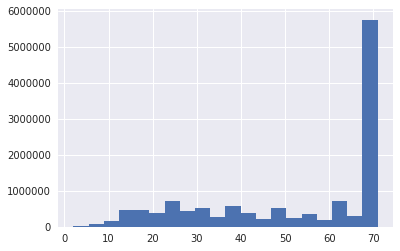

In [53]:
df['Tenure_new'].hist(bins=20)

In [54]:
Old_2015['Enrollment_Date'].describe()

count                 3995359
unique                    677
top       2014-02-24 00:00:00
freq                  1710763
first     2014-02-24 00:00:00
last      2019-06-19 00:00:00
Name: Enrollment_Date, dtype: object

In [58]:
(130175+113936)/Customer.shape[0]

0.39388433779263676

In [60]:
Customer.groupby(Customer["Enrollment_Date"].dt.month).count()

Unique_Customer_ID  Unique_Company_ID  Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary  Prior_Customer_Flag  Street1  Street2    City   State     Zip  Status  Term_Date  Active  Client ID  Account Name  Current Eligibles  Eligibles at time of Launch  Industry  NAICS Code  NAICS Description  Broker  Launch Date  Termination Date  Affiliate/Fed Gov?  CLIENT CODE  CLIENT NAME  CLIENT AR    Cash     TPA
Enrollment_Date                                                                                                                                                                                                                                                                                                                                                                                                                                               
1                             17825              17825            17825                    17825            17820            16342                17825    17822     4214   17821   17825   17825   17823       3117   17066      17066         17066              15111                        16883     17066       15121              15124   11971        16991              1057               16991         9266         9266       9266    9266    9619
2                            260275             260275           260275                   260275           260228           225905               260275   260243    56796  260240  260274  260274  260123      57975  249517     249517        249517             198025                       247116    249517      202155             203455  165975       247276             33029              247276       106109       106109     106109  106109  119554
3                             27655              27655            27655                    27655            27653            24932                27655    27651     6255   27652   27655   27655   27609       4402   26284      26284         26284              23329                        26035     26284       23400              23421   19007        26125              1769               26125        13417        13417      13417   13417   14280
4                             24406              24406            24406                    24406            24402            21797                24406    24400     5471   24400   24406   24403   24358       4032   23137      23137         23137              20357                        22924     23137       20386              20416   16755        23017              1569               23017        11463        11463      11463   11463   12118
5                             25534              25534            25534                    25534            25532            23102                25534    25531     5619   25532   25534   25533   25502       4468   24264      24264         24264              21624                        24081     24264       21698              21704   17448        24166              1607               24166        12672        12672      12672   12672   13204
6                             22784              22784            22784                    22784            22776            20742                22784    22782     5289   22783   22784   22784   22782       3984   21700      21700         21700              18992                        21529     21700       19053              19066   15060        21588              1680               21588        11387        11387      11387   11387   11963
7                             35921              35921            35921                    35921            35919            32774                35921    35916     8085   35918   35921   35921   35918       5574   34205      34205         34205              31082                        33976     34205       31157              31183   26295        34068              1830               34068        20285        20285      20285   20285   

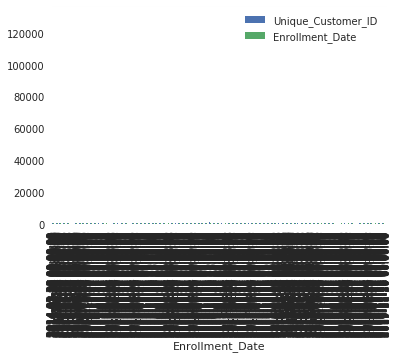

In [63]:
Customer[['Unique_Customer_ID','Enrollment_Date']].groupby(Customer["Enrollment_Date"]).count().plot(kind="bar")

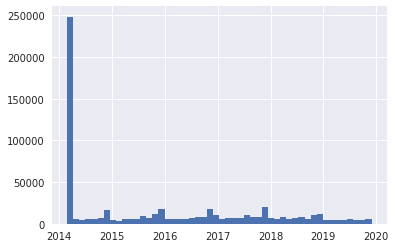

In [66]:
Customer['Enrollment_Date'].hist(bins=50)
plt.show()

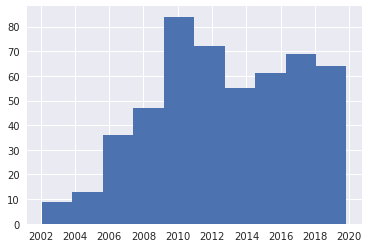

In [67]:
Client['Launch Date'].hist()

In [68]:
Customer['Y'] = Customer['Enrollment_Date'].dt.year

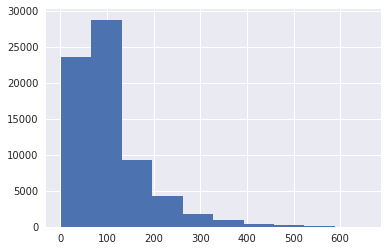

In [69]:
Customer[Customer['Y']==2015]['Customer_Tenure'].hist()

Customer_Tenure  enroll_to_today
count     69338.000000     69347.000000
mean        108.100911        49.925303
std          74.678458         3.347325
min           1.000000        46.000000
25%          62.000000        47.000000
50%          77.000000        49.000000
75%         129.000000        52.000000
max         654.000000        57.000000

In [72]:
Customer['enroll_to_today'] = (pd.to_datetime('11-01-2019') - Customer['Enrollment_Date'])/np.timedelta64(1, 'M')
Customer['enroll_to_today'] = Customer['enroll_to_today'].apply(lambda x: int(x) if (pd.notnull(x)) & (x>0) else np.nan)

In [74]:
Customer[Customer['Y']==2015][['Customer_Tenure','enroll_to_today']].describe()

Customer_Tenure  enroll_to_today
count     69338.000000     69347.000000
mean        108.100911        49.925303
std          74.678458         3.347325
min           1.000000        46.000000
25%          62.000000        47.000000
50%          77.000000        49.000000
75%         129.000000        52.000000
max         654.000000        57.000000

In [77]:
# Customer[Customer['Y']==2016][['Customer_Tenure','enroll_to_today']].describe()

In [78]:
# Customer[Customer['Y']==2017][['Customer_Tenure','enroll_to_today']].describe()

In [80]:
Customer[(Customer['Y']==2015)&(Customer['Customer_Tenure']<Customer['enroll_to_today'])][['Unique_Customer_ID','Customer_Tenure','enroll_to_today','Enrollment_Date']]

Unique_Customer_ID  Customer_Tenure  enroll_to_today Enrollment_Date
295305           300525443             54.0             57.0      2015-01-01
295324           300525516             48.0             57.0      2015-01-01
295330           300525540             20.0             57.0      2015-01-02
295346           300525581             36.0             57.0      2015-01-02
295376           300525771             43.0             57.0      2015-01-03
295394           300525871             19.0             57.0      2015-01-04
295540           300526568             39.0             57.0      2015-01-02
295573           300526664             47.0             57.0      2015-01-02
295577           300526675             21.0             57.0      2015-01-03
295594           300526777             52.0             57.0      2015-01-04
295606           300526803             14.0             57.0      2015-01-04
295613           300526825             30.0             57.0      2015-01-04
295820           300529426             53.0             57.0      2015-01-04
295832           300529463             32.0             57.0      2015-01-04
295992           300531036             18.0             57.0      2015-01-05
296263           300538057             48.0             57.0      2015-01-09
296272           300538104             34.0             57.0      2015-01-10
296273           300538108             46.0             57.0      2015-01-10
296304           300538204             48.0             57.0      2015-01-11
296329           300538310             35.0             57.0      2015-01-12
296384           300538528             39.0             57.0      2015-01-14
296385           300538529             50.0             57.0      2015-01-14
296398           300538613             54.0             57.0      2015-01-15
296467           300540152             22.0             57.0      2015-01-10
296498           300540289             24.0             57.0      2015-01-12
296526           300540401             55.0             57.0      2015-01-13
296587           300540609             42.0             57.0      2015-01-15
296617           300540702             44.0             57.0      2015-01-16
296666           300541191             50.0             57.0      2015-01-11
296718           300541375             52.0             57.0      2015-01-13
296747           300541501             26.0             57.0      2015-01-14
296751           300541527             34.0             57.0      2015-01-14
296802           300542068             55.0             57.0      2015-01-10
296827           300542178             37.0             57.0      2015-01-11
296861           300548022             45.0             57.0      2015-01-16
296901           300548139             16.0             57.0      2015-01-17
296931           300548298             43.0             57.0      2015-01-18
296934           300548306             27.0             57.0      2015-01-18
296984           300548509             25.0             57.0      2015-01-20
297010           300548612             27.0             57.0      2015-01-21
297012           300548619             41.0             57.0      2015-01-21
297014           300548626             49.0             57.0      2015-01-21
297020           300548646             28.0             57.0      2015-01-21
297041           300548743             56.0             57.0      2015-01-21
297064           300548851             46.0             57.0      2015-01-22
297143           300551145             37.0             57.0      2015-01-17
297151           300551186             46.0             57.0      2015-01-17
297178           300551318             50.0             57.0      2015-01-19
297181           300551330             33.0             57.0      2015-01-19
297188           300551353             50.0             57.0      2015-01-19
297242           300551601             20.0             57.0      2015-01-21
2973

In [81]:
1186/Customer[Customer['Y']==2016].shape[0]

0.016520176623810785

In [82]:
ab_cust = Old_2015[(Old_2015['Y']==2015)&(Old_2015['Old_2015_Tenure']<Old_2015['enroll_to_today'])]['Unique_Old_2015_ID'].tolist()

In [83]:
Old_2015['enroll_to_today'] = (pd.to_datetime('11-01-2019') - Old_2015['Enrollment_Date'])/np.timedelta64(1, 'M')
Old_2015['enroll_to_today'] = Old_2015['enroll_to_today'].apply(lambda x: int(x) if (pd.notnull(x)) & (x>0) else np.nan)

In [89]:
ab_cust = Old_2015[(Old_2015['Customer_Tenure']<Old_2015['enroll_to_today'])]['Unique_Customer_ID'].unique().tolist()

In [90]:
len(ab_cust)

2968

In [91]:
Old_2015['Unique_Customer_ID'].nunique()

229568

In [92]:
New_2019[New_2019['Unique_Customer_ID'].isin(ab_cust)]['Unique_Customer_ID'].nunique()

1393

In [93]:
Old_2015.head()

Unique_Order_ID  Unique_Customer_ID  Order_Amount  Product_Markup  Payments_Due  Current_Balance Date_account_went_delinquent Default_Status Delinquency_Bucket  Losses Auto_Pay_Enrollment Order_Closed_Flag Type_of_Backup_Payment  Spending_Limit_at_time_of_Order  Tenure_at_time_of_Order  Salary_at_time_of_Order        Street1_x     Street2_x    City_x State_x    Zip_x                                      Items_Ordered Year_and_Month Customer_Status Order_Date      YQ  Year  Payment_Order  Bad  Ever_Bad  2os_loss  Unique_Company_ID Enrollment_Date  Assigned_Spending_Limit  Customer_Tenure  Customer_Salary Prior_Customer_Flag        Street1_y Street2_y    City_y State_y  Zip_y Status Term_Date      Active  Client ID           Account Name  Current Eligibles  Eligibles at time of Launch       Industry  NAICS Code                      NAICS Description          Broker Launch Date Termination Date Affiliate/Fed Gov? CLIENT CODE CLIENT NAME CLIENT AR Cash       TPA Flag  enroll_to_today
11  YCCZIMM1449606           173585108        349.57             NaN          6.72           168.00                   2014-09-30           151+               151+     0.0                  PD                 N                    ACH                             31.9                    146.0                  28308.8  397 PARKWAY PLZ  EL CAJON, CA  EL CAJON      CA  92020.0  The SAK Ventura Convertible Backpack Black; Ji...     2014-12-01             LOA 2014-01-17  2014Q4  2014           12.0    1         1    168.00             2309.0      2014-02-24                   3190.0            146.0          28308.8        Repeat Buyer  750 SCRANTON ST     APT 8  EL CAJON      CA  92020    LOA       NaT  Terminated     2309.0  YANKEE CANDLE COMPANY             2104.0                       1999.0  Manufacturing    339999.0  All Other Miscellaneous Manufacturing  Beneplace, Inc  2012-06-15       2014-12-31          Affiliate         NaN         NaN       NaN  NaN  PAYLOGIX  Old             68.0
12  YCCZIMM1449606           173585108        349.57             NaN          6.72           168.00                   2014-09-30           151+               151+     0.0                  PD                 N                    ACH                             31.9                    146.0                  28308.8  397 PARKWAY PLZ  EL CAJON, CA  EL CAJON      CA  92020.0  The SAK Ventura Convertible Backpack Black; Ji...     2015-01-01             LOA 2014-01-17  2015Q1  2015           13.0    1         2    168.00             2309.0      2014-02-24                   3190.0            146.0          28308.8        Repeat Buyer  750 SCRANTON ST     APT 8  EL CAJON      CA  92020    LOA       NaT  Terminated     2309.0  YANKEE CANDLE COMPANY             2104.0                       1999.0  Manufacturing    339999.0  All Other Miscellaneous Manufacturing  Beneplace, Inc  2012-06-15       2014-12-31          Affiliate         NaN         NaN       NaN  NaN  PAYLOGIX  Old             68.0
13  YCCZIMM1449606           173585108        349.57             NaN          6.72           168.00                   2014-09-30           151+               151+     0.0                  PD                 N                    ACH                             31.9                    146.0                  28308.8  397 PARKWAY PLZ  EL CAJON, CA  EL CAJON      CA  92020.0  The SAK Ventura Convertible Backpack Black; Ji...     2015-02-01             LOA 2014-01-17  2015Q1  2015           14.0    1         3    168.00             2309.0      2014-02-24                   3190.0            146.0          28308.8        Repeat Buyer  750 SCRANTON ST     APT 8  EL CAJON      CA  92020    LOA       NaT  Terminated     2309.0  YANKEE CANDLE COMPANY             2104.0                       1999.0  Manufacturing    339999.0  All Other Miscellaneous Manufacturing  Beneplace, Inc  2012-06-15       2014-12-31          Affiliate         NaN         NaN       NaN  NaN  PAYLOGIX  Old             68.0
14  YCCZIMM

In [122]:
var='Tenure_new'
tenure_cut_labels = ['[0-50]','[50-100]', '[100-150]', '[150-200]', '[200-300]','[300+]']
tenure_cut_bins = [0,50,100,150, 200, 300,np.inf]
df[var+'_bin'] = pd.cut(df[var], bins=tenure_cut_bins, labels=tenure_cut_labels)
df.pivot_table(index ='Tenure_new_bin',values='Unique_Customer_ID',columns='Flag',aggfunc='nunique')

Flag               New    Old
Tenure_new_bin               
[0-50]          139001  79698
[50-100]        100586  70469
[100-150]        55307  44759
[150-200]        37162  28470
[200-300]        34416  21947
[300+]           14221  11871

In [43]:
tenure_loss = df[(df['Bad']==1)&(df['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Tenure_new_bin',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()

In [125]:
tenure_loss

Tenure_new_bin     loss_New    loss_Old
0         [0-50]  18820713.11  7067828.85
1       [50-100]  13218787.19  6266378.64
2      [100-150]   5505012.20  3051010.22
3      [150-200]   3114609.38  1741341.57
4      [200-300]   2561747.19  1229692.72
5         [300+]   1196914.63   653900.61

In [123]:
tenure_loss = df[(df['Bad']==1)&(df['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Tenure_new_bin',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()
prefix = 'loss_'
new_names = [(i,prefix + i) for i in ['New','Old']]
tenure_loss.rename(columns = dict(new_names), inplace=True)

tenure_bal = df.pivot_table(values = 'Current_Balance',index = 'Tenure_new_bin',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()
prefix = 'Balance_'
new_names = [(i,prefix + i) for i in ['New','Old']]
tenure_bal.rename(columns = dict(new_names), inplace=True)

In [126]:
tenure_bal

Tenure_new_bin   Balance_New   Balance_Old
0         [0-50]  1.033315e+09  5.470720e+08
1       [50-100]  8.916135e+08  5.773589e+08
2      [100-150]  5.460879e+08  3.879380e+08
3      [150-200]  3.735955e+08  2.670178e+08
4      [200-300]  3.848856e+08  2.216212e+08
5         [300+]  1.594306e+08  1.272325e+08

In [127]:
tenure = tenure_bal.merge(tenure_loss, how='left',on='Tenure_new_bin')
tenure.to_csv('../data/tenure.csv',index = False)
tenure

Tenure_new_bin   Balance_New   Balance_Old     loss_New    loss_Old
0         [0-50]  1.033315e+09  5.470720e+08  18820713.11  7067828.85
1       [50-100]  8.916135e+08  5.773589e+08  13218787.19  6266378.64
2      [100-150]  5.460879e+08  3.879380e+08   5505012.20  3051010.22
3      [150-200]  3.735955e+08  2.670178e+08   3114609.38  1741341.57
4      [200-300]  3.848856e+08  2.216212e+08   2561747.19  1229692.72
5         [300+]  1.594306e+08  1.272325e+08   1196914.63   653900.61

In [128]:
df.pivot_table(values = 'Unique_Customer_ID',index = 'Tenure_new_bin',columns='Flag',aggfunc='nunique').rename_axis(None,axis=1).reset_index()

Tenure_new_bin     New    Old
0         [0-50]  139001  79698
1       [50-100]  100586  70469
2      [100-150]   55307  44759
3      [150-200]   37162  28470
4      [200-300]   34416  21947
5         [300+]   14221  11871

In [94]:
var='Customer_Tenure'
tenure_cut_labels = ['[0-50]','[50-100]', '[100-150]', '[150-200]', '[200-300]','[300+]']
tenure_cut_bins = [0,50,100,150, 200, 300,np.inf]

In [95]:
New_2019[var+'_bin'] = pd.cut(New_2019[var], bins=tenure_cut_bins, labels=tenure_cut_labels)
New_2019.groupby('Customer_Tenure_bin').agg({'Current_Balance':'sum'})

Current_Balance
Customer_Tenure_bin                 
[0-50]                  8.793964e+08
[50-100]                9.795954e+08
[100-150]               5.520907e+08
[150-200]               4.020767e+08
[200-300]               4.062045e+08
[300+]                  1.702520e+08

In [96]:

New_2019['enroll_to_today'] = (pd.to_datetime('11-01-2019') - New_2019['Enrollment_Date'])/np.timedelta64(1, 'M')
New_2019['enroll_to_today'] = New_2019['enroll_to_today'].apply(lambda x: int(x) if (pd.notnull(x)) & (x>0) else np.nan)

In [ ]:
New_2019[New_2019['Unique_Customer_ID'].isin(ab_cust)]['Unique_Customer_ID'].nunique()

In [102]:
New_2019[(New_2019['Customer_Tenure']<=50)]['Unique_Customer_ID'].nunique()

111789

In [101]:
New_2019[(New_2019['Customer_Tenure']<=50)&(New_2019['Customer_Tenure']<New_2019['enroll_to_today'])]['Unique_Customer_ID'].nunique()#[['Enrollment_Date','Customer_Tenure','enroll_to_today']]

4066

### Nopay vs Other C/O

In [131]:
# How to create NoPay_Flag
# for each OrderID, get the intial balance and it's C/O balance, if they're the same, then it's treated as NoPay 
order_list = df['Unique_Order_ID'].unique().tolist()
Initial_bal = Perf[Perf['Unique_Order_ID'].isin(order_list)].groupby('Unique_Order_ID').head(1)
CO_bal = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)]

# Merge above two dfs to compare balance
CO_new = CO_bal[['Unique_Order_ID','Unique_Customer_ID','2os_loss','Year','Account Name','Flag']].merge(Initial_bal[['Unique_Order_ID','Current_Balance']], how = 'left', on='Unique_Order_ID')

# Note that the criteria here is using 95%~105% of intial balance range, because when an order chargeoff,
# the 2os_loss could be very similar to initial balance but with a <= $1 difference, we should take this issue into consideration
CO_new['NoPay_Flag'] = CO_new.apply(lambda x: 1 if (0.95 * x['Current_Balance'] <= x['2os_loss']) & (1.05 * x['Current_Balance'] >= x['2os_loss']) else 0, axis=1)
CO_new['NoPay_Flag'].value_counts()

0    124366
1     17791
Name: NoPay_Flag, dtype: int64

In [132]:
CO_new.head()

Unique_Order_ID  Unique_Customer_ID  2os_loss  Year           Account Name Flag  Current_Balance  NoPay_Flag
0  YCCZIMM1449606           173585108    168.00  2014  YANKEE CANDLE COMPANY  Old           336.00           0
1  YCCZIMM1404330           173585108    128.00  2014  YANKEE CANDLE COMPANY  Old           320.00           0
2  YCCZIMM1281194           173585108     32.31  2015  YANKEE CANDLE COMPANY  Old           560.04           0
3  YCCWIGH1391740           173799537     44.96  2015  YANKEE CANDLE COMPANY  Old          1103.22           0
4  YCCWAIT1307266           237471452     56.64  2015  YANKEE CANDLE COMPANY  Old           736.32           0

In [134]:
CO_new.pivot_table(values='2os_loss',index='NoPay_Flag',columns='Flag',aggfunc='sum')

Flag                New          Old
NoPay_Flag                          
0           33599733.77  16347751.11
1           10833254.41   3872000.12

In [ ]:
# Annual Flow-in NoPay pbads by Client
NoPay_pbads = CO_new[CO_new['NoPay_Flag']==1].pivot_table(
    values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
NoPay_pbads.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [135]:
df[(df['Bad']==1)&(df['Ever_Bad']==1)]['2os_loss'].sum()

64652739.41000001

In [17]:
df['City_y'].nunique()

14239

### Geographic - City

In [16]:
pop = df.pivot_table(values='Unique_Customer_ID', index='City_y', columns='Flag', aggfunc='nunique').rename_axis(
    None, axis=1).reset_index()  # .sort_values('New',ascending=False)

In [17]:
prefix = 'Pop_'
new_names = [(i,prefix + i) for i in ['New','Old']]
pop.rename(columns = dict(new_names), inplace=True)

In [18]:
CITY_loss = df[(df['Bad']==1)&(df['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'City_y',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()
prefix = 'loss_'
new_names = [(i,prefix + i) for i in ['New','Old']]
CITY_loss.rename(columns = dict(new_names), inplace=True)

CITY_bal = df.pivot_table(values = 'Current_Balance',index = 'City_y',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()
prefix = 'Balance_'
new_names = [(i,prefix + i) for i in ['New','Old']]
CITY_bal.rename(columns = dict(new_names), inplace=True)

In [19]:
CITY = CITY_bal.merge(CITY_loss, how='left',on='City_y')
CITY['loss_rate_New'] = CITY['loss_New']/CITY['Balance_New']*12
CITY['loss_rate_Old'] = CITY['loss_Old']/CITY['Balance_Old']*12
CITY['delta_loss'] = CITY['loss_rate_New'] - CITY['loss_rate_Old']
# CITY.sort_values('Balance_New',ascending=False)
CITY = CITY.merge(pop, how='left',on='City_y')

In [14]:
# CITY[(CITY['Pop_New']>200)&(CITY['delta_loss']>0.04)].sort_values('delta_loss',ascending=False)

In [20]:
CITY = CITY.fillna(0)

In [21]:
def city_size(x):
    """
    ~97% small city
    ~1.4% middle city
    ~0.6% big city
    """
    if x['Pop_New'] <= 200:
        return 'Small City'
    elif x['Pop_New'] <= 500:
        return 'Middle City'
    else:
        return 'Big City'

In [22]:
CITY['Size'] = CITY.apply(lambda x: city_size(x),axis=1)

In [75]:
# CITY.groupby('Size').size()/CITY.shape[0]

In [23]:
CITY[(CITY['Size']=='Big City')&(CITY['delta_loss']>0.05)].sort_values('delta_loss',ascending=False).head(10)

City_y  Balance_New  Balance_Old   loss_New   loss_Old  loss_rate_New  loss_rate_Old  delta_loss  Pop_New  Pop_Old      Size
11099  SAINT LOUIS  11328728.88   4867890.01  382075.99   78058.26       0.404715       0.192424    0.212291   1140.0    497.0  Big City
2980        DALLAS  19597164.33  12189893.88  415033.04  141648.93       0.254139       0.139442    0.114696   1794.0   1296.0  Big City
8047     MILWAUKEE   9799726.22   7158943.68  224094.21   99500.07       0.274409       0.166784    0.107624    916.0    694.0  Big City
1078    BIRMINGHAM   8953293.67   6053762.25  159304.89   53486.06       0.213515       0.106022    0.107492   1019.0    670.0  Big City
464      ARLINGTON   6619313.28   4504725.38  119257.97   42355.15       0.216200       0.112829    0.103371    627.0    481.0  Big City
3022     DAVENPORT   3833145.29   2004947.69   43109.34    6256.08       0.134958       0.037444    0.097514    553.0    284.0  Big City
2317    CINCINNATI   9670707.85   7890498.83  217409.95  113908.98       0.269775       0.173235    0.096541   1117.0    905.0  Big City
6956     LEXINGTON   7082341.70   3326316.61  118357.78   29475.74       0.200540       0.106337    0.094204    812.0    429.0  Big City
12521        TAMPA  15812350.87   8814004.54  230760.27   62455.21       0.175124       0.085031    0.090093   1578.0    980.0  Big City
6710     LANCASTER  10656519.31   6524351.07  193080.42   70660.46       0.217422       0.129963    0.087459   1006.0    678.0  Big City

In [24]:
CITY[(CITY['Size']=='Middle City')&(CITY['delta_loss']>0.05)].sort_values('delta_loss',ascending=False).head(10)

City_y  Balance_New  Balance_Old   loss_New  loss_Old  loss_rate_New  loss_rate_Old  delta_loss  Pop_New  Pop_Old         Size
4376   FORT SMITH   1585746.27   1401896.31   57377.24  14983.88       0.434197       0.128260    0.305938    223.0    183.0  Middle City
2698      CORDELE   2668008.91    430960.52   68631.75   1485.38       0.308687       0.041360    0.267327    277.0     73.0  Middle City
9191        OCALA   2006083.83   1331651.41   56708.40  11806.63       0.339219       0.106394    0.232825    253.0    160.0  Middle City
9170      OAKLAND   2629417.16   2106154.01   63753.44  17067.37       0.290955       0.097243    0.193712    262.0    231.0  Middle City
5998       IRVING   2940869.00   2383250.12   88526.08  33276.51       0.361224       0.167552    0.193672    302.0    276.0  Middle City
12344    SUITLAND   2821177.00   2171480.07   57107.20  12380.97       0.242908       0.068420    0.174488    219.0    187.0  Middle City
2213      CHESTER   2767678.88   1685558.61   64056.99  14505.28       0.277736       0.103267    0.174468    255.0    187.0  Middle City
13445    WATERLOO   2098747.90    993101.83   57353.15  12861.54       0.327928       0.155411    0.172517    221.0    131.0  Middle City
344      ANDERSON   2898256.26   1121611.64   57995.62   6459.19       0.240126       0.069106    0.171020    385.0    164.0  Middle City
6057      JAMAICA   5417998.24   2880854.88  136082.53  31745.08       0.301401       0.132232    0.169169    418.0    268.0  Middle City

In [25]:
CITY[(CITY['Size']=='Small City')&(CITY['delta_loss']>0.05)&(CITY['Pop_New']>100)].sort_values('delta_loss',ascending=False).head(10)

City_y  Balance_New  Balance_Old  loss_New  loss_Old  loss_rate_New  loss_rate_Old  delta_loss  Pop_New  Pop_Old        Size
12538       TARBORO    898198.11    382917.88  35584.27   6531.82       0.475409       0.204696    0.270713    113.0     51.0  Small City
11058  SAINT ALBANS   1073356.49    308198.05  26748.80   1035.84       0.299048       0.040331    0.258717    110.0     51.0  Small City
8282     MORRISTOWN   1198918.40    320029.05  37118.81   3102.21       0.371523       0.116322    0.255201    103.0     49.0  Small City
9622      PARKVILLE   1709638.30   1200072.20  40582.43   4285.69       0.284849       0.042854    0.241995    149.0    123.0  Small City
1561          BRYAN   1390877.20    258987.26  26996.72     81.15       0.232918       0.003760    0.229158    163.0     37.0  Small City
5320       HARTFORD   2000740.30    663930.87  44770.16   2254.80       0.268522       0.040754    0.227768    166.0     60.0  Small City
2653         CONWAY   1129509.79   1263349.11  31920.07  13040.75       0.339121       0.123868    0.215253    137.0    120.0  Small City
315        AMERICUS   1808959.08    372727.63  37891.08   1199.71       0.251356       0.038625    0.212731    183.0     42.0  Small City
11477         SELMA   1702145.49   1010934.81  36302.63   4272.31       0.255931       0.050713    0.205218    184.0    104.0  Small City
3619         EASTON    947827.47    377279.15  16491.54    672.60       0.208792       0.021393    0.187398    113.0     39.0  Small City

In [28]:
CITY['Expected New Loss $'] = CITY['Balance_New'] * CITY['loss_rate_Old'] / 12
CITY['Actual New Loss $'] = CITY['loss_New']
CITY['Marginal Loss Dollars'] = CITY['Actual New Loss $'] - CITY['Expected New Loss $']
CITY['Balance_share_New'] = CITY['Balance_New']/CITY['Balance_New'].sum()
CITY['Contribution to Risk Worsening'] = CITY['Marginal Loss Dollars']/CITY['Marginal Loss Dollars'].sum()

- Calculate Other Loss Rate by snapshot

In [29]:
Total_loss_New = CITY['loss_New'].sum()
Total_loss_Old = CITY['loss_Old'].sum()

In [47]:
def other_lr(df,size,flag):
    tops = df[df['Size'] == size].sort_values('delta_loss', ascending=False).head(10)
    loss = df[df['Size'] == size]['loss_'+flag].sum() - tops['loss_'+flag].sum()
    balance = (df[df['Size'] == size]['Balance_'+flag].sum()-tops['Balance_'+flag].sum())
    return loss/balance*12


In [48]:
print('Big City - Other Loss Rate - New',other_lr(CITY,'Big City','New'))
print('Big City - Other Loss Rate - Old',other_lr(CITY,'Big City','Old'))
print('Middle City - Other Loss Rate - New',other_lr(CITY,'Middle City','New'))
print('Middle City - Other Loss Rate - Old',other_lr(CITY,'Middle City','Old'))

Big City - Other Loss Rate - New 0.16002663286569968
Big City - Other Loss Rate - Old 0.11708380476757967
Middle City - Other Loss Rate - New 0.15808654243402523
Middle City - Other Loss Rate - Old 0.1163651292825465


In [61]:
def other_balance_share(df,size,var):
    tops = df[df['Size'] == size].sort_values('delta_loss', ascending=False).head(10)
    other = (df[df['Size'] == size][var].sum()-tops[var].sum())
    total = df[var].sum()    
    return other/total



In [62]:
print('Big City - Other Balance Share',other_balance_share(CITY,'Big City','Balance_New'))
print('Middle City - Other Balance Share',other_balance_share(CITY,'Middle City','Balance_New'))

Big City - Other Balance Share 0.2873586267502954
Middle City - Other Balance Share 0.1802955816074272


In [67]:
print('Big City - Other Balance Share',other_balance_share(CITY,'Big City','Balance_Old'))
print('Middle City - Other Balance Share',other_balance_share(CITY,'Middle City','Balance_Old'))

Big City - Other Balance Share 0.28464608371413713
Middle City - Other Balance Share 0.17988111891961855


In [96]:
var = 'Balance_Old'
tops = CITY.sort_values('Contribution to Risk Worsening', ascending=False).head(10)
other = (CITY[var].sum()-tops[var].sum())
total = CITY[var].sum()    
other/total

0.9218741362940123

In [97]:
var = 'Balance_New'
tops = CITY.sort_values('Contribution to Risk Worsening', ascending=False).head(10)
other = (CITY[var].sum()-tops[var].sum())
total = CITY[var].sum()    
other/total

0.9175079820095002

In [59]:
def other_risk_worsening(df,size):
    tops = df[df['Size'] == size].sort_values('delta_loss', ascending=False).head(10)
    loss_old = df[df['Size'] == size]['loss_Old'].sum() - tops['loss_Old'].sum()
    balance_old = (df[df['Size'] == size]['Balance_Old'].sum()-tops['Balance_Old'].sum())
    loss_rate_old = loss_old/balance_old*12
    
    
    loss_new = df[df['Size'] == size]['loss_New'].sum() - tops['loss_New'].sum()
    balance_new = (df[df['Size'] == size]['Balance_New'].sum()-tops['Balance_New'].sum())
    other_margin_loss = loss_new - balance_new*loss_rate_old/12
    risk_worsening_contrib = other_margin_loss/df['Marginal Loss Dollars'].sum()
    
    return risk_worsening_contrib



In [60]:
print('Big City - Other Contribution Share',other_risk_worsening(CITY,'Big City'))
print('Middle City - Other Contribution Share',other_risk_worsening(CITY,'Middle City'))

Big City - Other Contribution Share 0.2742019213425785
Middle City - Other Contribution Share 0.16714743077822636


In [85]:
CITY[(CITY['Pop_New']<50)].shape[0]/CITY.shape[0]

0.9156541891986797

In [86]:
CITY[(CITY['Pop_New']<50)]['loss_New'].sum()/CITY['loss_New'].sum()

0.21851238975425605

In [75]:
citys = CITY[(CITY['Size']!='Small City')&(CITY['delta_loss']>0.05)]['City_y'].tolist()#136 citys

In [65]:
# CITY.to_csv('../data/CITY.csv',index = False)

### Geographic - Zipcode

In [79]:
df_zip = df[df['City_y'].isin(citys)]

In [114]:
df_zip['Zip_y'] = df_zip['Zip_y'].astype(int)

In [115]:
pop = df_zip.pivot_table(values='Unique_Customer_ID', index='Zip_y', columns='Flag', aggfunc='nunique').rename_axis(
    None, axis=1).reset_index()

In [116]:
prefix = 'Pop_'
new_names = [(i,prefix + i) for i in ['New','Old']]
pop.rename(columns = dict(new_names), inplace=True)

In [117]:
Zip_loss = df_zip[(df_zip['Bad']==1)&(df_zip['Ever_Bad']==1)].pivot_table(values = '2os_loss',index = 'Zip_y',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()
prefix = 'loss_'
new_names = [(i,prefix + i) for i in ['New','Old']]
Zip_loss.rename(columns = dict(new_names), inplace=True)

Zip_bal = df_zip.pivot_table(values = 'Current_Balance',index = 'Zip_y',columns='Flag',aggfunc='sum').rename_axis(None,axis=1).reset_index()
prefix = 'Balance_'
new_names = [(i,prefix + i) for i in ['New','Old']]
Zip_bal.rename(columns = dict(new_names), inplace=True)

In [118]:
Zip = Zip_bal.merge(Zip_loss, how='left',on='Zip_y')
Zip['loss_rate_New'] = Zip['loss_New']/Zip['Balance_New']*12
Zip['loss_rate_Old'] = Zip['loss_Old']/Zip['Balance_Old']*12
Zip['delta_loss'] = Zip['loss_rate_New'] - Zip['loss_rate_Old']
# Zip.to_csv('../data/Zip.csv',index = False)
# Zip.sort_values('Balance_New',ascending=False)

In [119]:
Zip = Zip.merge(pop, how='left',on='Zip_y')
zip_city_map = df_zip[['Zip_y','City_y']].drop_duplicates(keep='first')
Zip = Zip.merge(zip_city_map,on='Zip_y',how='left')

In [120]:
Zip['Expected New Loss $'] = Zip['Balance_New'] * Zip['loss_rate_Old'] / 12
Zip['Actual New Loss $'] = Zip['loss_New']
Zip['Marginal Loss Dollars'] = Zip['Actual New Loss $'] - Zip['Expected New Loss $']
Zip['Balance_share_New'] = Zip['Balance_New']/Zip['Balance_New'].sum()
Zip['Contribution to Risk Worsening'] = Zip['Marginal Loss Dollars']/Zip['Marginal Loss Dollars'].sum()

In [159]:
# Zip[(Zip['Pop_New']>100)&(Zip['delta_loss']>0.04)].sort_values('delta_loss',ascending=False)

In [160]:
# Zip[(Zip['Pop_New']>100)&(Zip['delta_loss']>0.04)&(Zip['Zip_y'].isin(duplicate_zips))].sort_values('delta_loss',ascending=False)

In [123]:
Zip.shape

(4106, 10)

In [139]:
zip_city_map.shape

(4178, 2)

In [144]:
duplicate_zips = zip_city_map.groupby(['Zip_y']).filter(lambda x: len(x)>1)['Zip_y'].tolist()

In [143]:
# zip_city_map.groupby(['Zip_y']).size().sort_values(ascending=False)

In [104]:
Zip[Zip['Pop_New']>=50]['Pop_New'].describe()

count    408.000000
mean      92.549020
std       48.334599
min       50.000000
25%       61.000000
50%       77.000000
75%      104.000000
max      335.000000
Name: Pop_New, dtype: float64

In [105]:
Zip[Zip['Pop_New']>=50].shape[0]/Zip.shape[0]

0.09936678032148076

In [120]:
Zip[Zip['Pop_New']>=50].shape[0]

408

In [148]:
Zip[Zip['Pop_New']>=100].shape[0]

132

In [149]:
Zip[Zip['Pop_New']>=200].shape[0]

22

In [121]:
def zip_size(x):
    """
    ~97% small zip
    ~1.4% middle zip
    ~0.6% big zip
    """
    if x['Pop_New'] >= 200:
        return 'Big Zip'
    elif x['Pop_New'] >= 100:
        return 'Middle Zip'
    elif x['Pop_New'] >= 50:
        return 'Small Zip'
    else:
        return 'Tiny Zip'

In [122]:
Zip['Size'] = Zip.apply(lambda x: zip_size(x),axis=1)

In [125]:
Zip[(Zip['Size']=='Big Zip')&(Zip['delta_loss']>0.05)].sort_values('delta_loss',ascending=False).head(10)

Zip_y  Balance_New  Balance_Old  loss_New  loss_Old  loss_rate_New  loss_rate_Old  delta_loss  Pop_New  Pop_Old          City_y  Expected New Loss $  Actual New Loss $  Marginal Loss Dollars  Balance_share_New  Contribution to Risk Worsening     Size
687   31015   2667788.76    409996.68  68631.75   1246.96       0.308713       0.036497    0.272216    276.0     71.0         CORDELE          8113.787341           68631.75           60517.962659           0.003115                        0.011898  Big Zip
1750  73505   1510806.43    795547.22  34615.35   6115.02       0.274942       0.092239    0.182703    209.0     98.0          LAWTON         11612.901539           34615.35           23002.448461           0.001764                        0.004522  Big Zip
423   20746   2812524.68   2131110.79  57095.93  12380.97       0.243607       0.069716    0.173892    216.0    184.0        SUITLAND         16339.734119           57095.93           40756.195881           0.003283                        0.008013  Big Zip
1781  75115   2610167.23   1764174.66  59194.75  15150.45       0.272142       0.103054    0.169088    223.0    160.0          DALLAS         22415.698970           59194.75           36779.051030           0.003047                        0.007231  Big Zip
1780  75115   2610167.23   1764174.66  59194.75  15150.45       0.272142       0.103054    0.169088    223.0    160.0          DESOTO         22415.698970           59194.75           36779.051030           0.003047                        0.007231  Big Zip
364   19120   2653884.45   1387820.02  47601.60  10401.49       0.215239       0.089938    0.125301    240.0    113.0    PHILADELPHIA         19890.441246           47601.60           27711.158754           0.003098                        0.005448  Big Zip
647   30134   2154903.28   1625725.26  29079.13   6994.49       0.161933       0.051629    0.110304    228.0    168.0    DOUGLASVILLE          9271.215631           29079.13           19807.914369           0.002516                        0.003894  Big Zip
201   10466   3611427.24   2153401.85  45473.92   8793.57       0.151100       0.049003    0.102097    278.0    166.0           BRONX         14747.520643           45473.92           30726.399357           0.004216                        0.006041  Big Zip
645   30127   2777738.62   2185707.60  28440.74   4417.36       0.122866       0.024252    0.098613    289.0    211.0  POWDER SPRINGS          5613.866864           28440.74           22826.873136           0.003243                        0.004488  Big Zip
700   31907   2616559.95    508954.81  45572.88   4909.99       0.209005       0.115766    0.093239    267.0     71.0        COLUMBUS         25242.483098           45572.88           20330.396902           0.003055                        0.003997  Big Zip

In [127]:
Zip[(Zip['Size']=='Middle Zip')&(Zip['delta_loss']>0.1)].sort_values('delta_loss',ascending=False).head(10)

Zip_y  Balance_New  Balance_Old  loss_New  loss_Old  loss_rate_New  loss_rate_Old  delta_loss  Pop_New  Pop_Old       City_y  Expected New Loss $  Actual New Loss $  Marginal Loss Dollars  Balance_share_New  Contribution to Risk Worsening        Size
1624  63136   1656675.97    694707.31  62871.69   6564.72       0.455406       0.113395    0.342011    148.0     62.0  SAINT LOUIS         15654.958163           62871.69           47216.731837           0.001934                        0.009283  Middle Zip
1787  75150   1517390.19    763996.88  55454.28   6352.90       0.438550       0.099784    0.338766    128.0     81.0       DALLAS         12617.627624           55454.28           42836.652376           0.001771                        0.008422  Middle Zip
1786  75150   1517390.19    763996.88  55454.28   6352.90       0.438550       0.099784    0.338766    128.0     81.0     MESQUITE         12617.627624           55454.28           42836.652376           0.001771                        0.008422  Middle Zip
947   34744   1142482.48    585587.24  27793.99    331.32       0.291933       0.006789    0.285143    132.0     73.0    KISSIMMEE           646.406324           27793.99           27147.583676           0.001334                        0.005337  Middle Zip
632   29720   1637786.72    553600.50  44431.62   1986.98       0.325549       0.043070    0.282478    181.0     89.0    LANCASTER          5878.335473           44431.62           38553.284527           0.001912                        0.007580  Middle Zip
844   33615   1113331.85    678765.76  28939.10   2824.53       0.311919       0.049935    0.261984    114.0     66.0        TAMPA          4632.878374           28939.10           24306.221626           0.001300                        0.004779  Middle Zip
2300  90044   1427481.83    740619.54  37334.37   4261.67       0.313848       0.069050    0.244798    120.0     73.0  LOS ANGELES          8214.010247           37334.37           29120.359753           0.001667                        0.005725  Middle Zip
1829  75243   1115993.33    491824.46  35659.13   6307.55       0.383434       0.153898    0.229536    104.0     69.0       DALLAS         14312.390499           35659.13           21346.739501           0.001303                        0.004197  Middle Zip
185   10453   1640471.11    818587.86  35953.19   2305.57       0.262997       0.033798    0.229198    123.0     74.0        BRONX          4620.421536           35953.19           31332.768464           0.001915                        0.006160  Middle Zip
1782  75134   1266630.23    767554.93  29926.64   3572.25       0.283524       0.055849    0.227675    107.0     76.0    LANCASTER          5894.978538           29926.64           24031.661462           0.001479                        0.004725  Middle Zip

In [129]:
Zip[(Zip['Size']=='Small Zip')&(Zip['delta_loss']>0.1)].sort_values('delta_loss',ascending=False).head()

Zip_y  Balance_New  Balance_Old  loss_New  loss_Old  loss_rate_New  loss_rate_Old  delta_loss  Pop_New  Pop_Old       City_y  Expected New Loss $  Actual New Loss $  Marginal Loss Dollars  Balance_share_New  Contribution to Risk Worsening       Size
1610  63121    910408.15    178372.37  38946.77    888.42       0.513354       0.059768    0.453585     72.0     21.0  SAINT LOUIS          4534.473633           38946.77           34412.296367           0.001063                        0.006766  Small Zip
1231  45224    656337.03    456760.77  27832.16   3299.44       0.508863       0.086683    0.422181     67.0     50.0   CINCINNATI          4741.091601           27832.16           23091.068399           0.000766                        0.004540  Small Zip
1758  75040    559136.22    510775.64  20998.65   2642.42       0.450666       0.062080    0.388586     54.0     59.0      GARLAND          2892.606097           20998.65           18106.043903           0.000653                        0.003560  Small Zip
613   29505    688389.46    323352.67  28836.59   3304.44       0.502679       0.122632    0.380048     68.0     42.0     FLORENCE          7034.862793           28836.59           21801.727207           0.000804                        0.004286  Small Zip
614   29505    688389.46    323352.67  28836.59   3304.44       0.502679       0.122632    0.380048     68.0     42.0      RALEIGH          7034.862793           28836.59           21801.727207           0.000804                        0.004286  Small Zip

In [130]:
# Zip.to_csv('../data/Zip.csv',index = False)

In [164]:
# Zip[Zip['City_y']=='SAINT LOUIS']

### - Zipcode deep dive

In [94]:
Zip[(Zip['Size']=='Big Zip')&(Zip['delta_loss']>0.05)].sort_values('delta_loss',ascending=False).head(10)['Zip_y'].tolist()

[31015,
 19120.0,
 30127,
 30238,
 30228,
 31907,
 30253.0,
 30253.0,
 30349.0,
 27610.0]

In [78]:
df[df['Zip_y']==31015]['City_y'].unique()

array(['CORDELE'], dtype=object)

### City - Deep Dive

In [18]:
def city_dd(df, city_name):
    """
    City Deep Dive
    """
    bal = df[(df['City_y']==city_name)].pivot_table(index='Account Name', values='Current_Balance', columns='Flag',
               aggfunc='sum').reset_index().rename_axis(None, axis=1)
    prefix = 'Balance_'
    new_names = [(i,prefix + i) for i in ['New','Old']]
    bal.rename(columns = dict(new_names), inplace=True)
    
    loss = df[(df['City_y']==city_name)&(df['Bad']==1)&(df['Ever_Bad']==1)].pivot_table(index='Account Name', values='2os_loss', columns='Flag',
               aggfunc='sum').reset_index().rename_axis(None, axis=1)
    prefix = 'Loss_'
    new_names = [(i,prefix + i) for i in ['New','Old']]
    loss.rename(columns = dict(new_names), inplace=True)
    
    city = bal.merge(loss, on='Account Name',how='left')
    city['lr_New'] = city['Loss_New']/city['Balance_New']*12
    city['lr_Old'] = city['Loss_Old']/city['Balance_Old']*12
    
    

    city['lr_delta'] = city['lr_New'] - city['lr_Old']
    city['lc_New'] = city['Loss_New']/city['Loss_New'].sum()
    city['lc_Old'] = city['Loss_Old']/city['Loss_Old'].sum()
    city['lc_delta'] = city['lc_New'] - city['lc_Old']
    
    return city.sort_values('lc_New',ascending=False)


In [12]:
def convert_type(x):
    try:
        return int(x)
    except:
        return np.nan
    
    

In [13]:
df['Zip_y'] = df['Zip_y'].apply(lambda x: convert_type(x))

In [26]:
def zip_dd(df, city_name):
    """
    Zipcode Deep Dive
    """
    bal = df[(df['City_y']==city_name)].pivot_table(index='Zip_y', values='Current_Balance', columns='Flag',
               aggfunc='sum').reset_index().rename_axis(None, axis=1)
    prefix = 'Balance_'
    new_names = [(i,prefix + i) for i in ['New','Old']]
    bal.rename(columns = dict(new_names), inplace=True)
    
    loss = df[(df['City_y']==city_name)&(df['Bad']==1)&(df['Ever_Bad']==1)].pivot_table(index='Zip_y', values='2os_loss', columns='Flag',
               aggfunc='sum').reset_index().rename_axis(None, axis=1)
    prefix = 'Loss_'
    new_names = [(i,prefix + i) for i in ['New','Old']]
    loss.rename(columns = dict(new_names), inplace=True)
    
    cust = df[(df['City_y']==city_name)].pivot_table(index='Zip_y', values='Unique_Customer_ID', columns='Flag',
           aggfunc='nunique').reset_index().rename_axis(None, axis=1)
    prefix = 'Unit_'
    new_names = [(i,prefix + i) for i in ['New','Old']]
    cust.rename(columns = dict(new_names), inplace=True)
    
    
    city = reduce(lambda x, y: pd.merge(x, y, on = 'Zip_y',how='left'), [bal,loss,cust])
    city['lr_New'] = city['Loss_New']/city['Balance_New']*12
    city['lr_Old'] = city['Loss_Old']/city['Balance_Old']*12
    city['lr_delta'] = city['lr_New'] - city['lr_Old']
    city['lc_New'] = city['Loss_New']/city['Loss_New'].sum()
    city['lc_Old'] = city['Loss_Old']/city['Loss_Old'].sum()
    city['lc_delta'] = city['lc_New'] - city['lc_Old']
    
    return city.sort_values('lc_New',ascending=False)



In [30]:
city_dd(df,'SAINT LOUIS').round(2).to_csv('../data/saint_louis.csv',index = False)
city_dd(df,'SAINT LOUIS').head(10).round(2)

Account Name  Balance_New  Balance_Old   Loss_New  Loss_Old  lr_New  lr_Old  lr_delta  lc_New  lc_Old  lc_delta
27  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...   4257784.15   2435919.89  215980.49  35043.11    0.61    0.17      0.44    0.57    0.45      0.12
17                             CHARTER COMMUNICATIONS   2475940.64          NaN  103869.62       NaN    0.50     NaN       NaN    0.27     NaN       NaN
20                                COMPASS GROUP (NEW)    525965.33          NaN   10166.62       NaN    0.23     NaN       NaN    0.03     NaN       NaN
21                                         DAVITA INC    480333.99    322755.46    9659.31   5445.63    0.24    0.20      0.04    0.03    0.07     -0.04
54                                     THE HOME DEPOT    360844.33    289388.92    4668.43   5267.53    0.16    0.22     -0.06    0.01    0.07     -0.06
4                                  AMERICAN RED CROSS    311060.80    228659.20    3779.19   3413.95    0.15    0.18     -0.03    0.01    0.04     -0.03
22                              DELTA AIR LINES, INC.    168620.58    127581.36    3579.42    572.66    0.25    0.05      0.20    0.01    0.01      0.00
36                           KOHL'S DEPARTMENT STORES     38224.77     15797.68    3038.37       NaN    0.95     NaN       NaN    0.01     NaN       NaN
1                            ADVANCE AUTO PARTS, INC.     40704.26      4232.66    2619.14       NaN    0.77     NaN       NaN    0.01     NaN       NaN
51                              SUNRISE SENIOR LIVING    167060.67      1606.02    2513.10       NaN    0.18     NaN       NaN    0.01     NaN       NaN

In [31]:
zip_dd(df,'SAINT LOUIS').round(2).to_csv('../data/saint_louis_zip.csv',index = False)
zip_dd(df,'SAINT LOUIS').head(10).round(2)

Zip_y  Balance_New  Balance_Old  Loss_New  Loss_Old  Unit_New  Unit_Old  lr_New  lr_Old  lr_delta  lc_New  lc_Old  lc_delta
37  63136.0   1656675.97    694707.31  62871.69   6564.72     148.0      62.0    0.46    0.11      0.34    0.16    0.08      0.08
23  63121.0    910408.15    178372.37  38946.77    888.42      72.0      21.0    0.51    0.06      0.45    0.10    0.01      0.09
46  63147.0    499052.07    168045.12  27455.39   5668.60      41.0      13.0    0.66    0.40      0.26    0.07    0.07     -0.00
36  63135.0    465760.18     86827.84  26729.51   1463.16      42.0      12.0    0.69    0.20      0.49    0.07    0.02      0.05
39  63138.0    783609.39    220437.74  23802.19   4989.71      81.0      24.0    0.36    0.27      0.09    0.06    0.06     -0.00
38  63137.0    747323.59    329113.99  22998.06   2902.47      67.0      35.0    0.37    0.11      0.26    0.06    0.04      0.02
20  63118.0    451860.01    258092.81  16916.81   7480.06      44.0      21.0    0.45    0.35      0.10    0.04    0.10     -0.05
15  63113.0    428084.02    136069.01  14557.13   1383.98      38.0      13.0    0.41    0.12      0.29    0.04    0.02      0.02
17  63115.0    430307.12    123192.91  14262.92    912.75      41.0      19.0    0.40    0.09      0.31    0.04    0.01      0.03
34  63133.0    266300.46     52342.05  13739.94   4297.55      23.0       4.0    0.62    0.99     -0.37    0.04    0.06     -0.02

In [27]:
city_dd(df,'DALLAS').head(10).round(2)

Account Name  Balance_New  Balance_Old   Loss_New  Loss_Old  lr_New  lr_Old  lr_delta  lc_New  lc_Old  lc_delta
71                            KOHL'S DEPARTMENT STORES   2061078.96    484255.87  140103.19   2479.37    0.82    0.06      0.75    0.34    0.02      0.32
46   FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...   2857238.58   2547042.80   71084.00  35400.81    0.30    0.17      0.13    0.17    0.25     -0.08
24                              CHARTER COMMUNICATIONS   1452524.24   1214563.26   36886.95  12550.25    0.30    0.12      0.18    0.09    0.09     -0.00
33                                          DAVITA INC    659570.30    409835.16   30804.82   3862.24    0.56    0.11      0.45    0.07    0.03      0.05
132                             WELLSTAR HEALTH SYSTEM   1757308.19   1483401.60   16986.23  17421.65    0.12    0.14     -0.02    0.04    0.12     -0.08
119                                     THE HOME DEPOT   1269804.88    673719.69   16675.03   6110.39    0.16    0.11      0.05    0.04    0.04     -0.00
25                                                CITI    224141.37    667474.17    7936.54  17921.57    0.42    0.32      0.10    0.02    0.13     -0.11
53                              G4S - SECURE SOLUTIONS    253235.28    145594.08    6889.78       NaN    0.33     NaN       NaN    0.02     NaN       NaN
3                             ADVANCE AUTO PARTS, INC.    248335.21     24107.15    6722.62       NaN    0.32     NaN       NaN    0.02     NaN       NaN
123                                      U.S. ONCOLOGY    617449.39    616388.01    5570.00   6425.60    0.11    0.13     -0.02    0.01    0.05     -0.03

In [28]:
zip_dd(df,'DALLAS').head(10).round(2)

Zip_y  Balance_New  Balance_Old  Loss_New  Loss_Old  Unit_New  Unit_Old  lr_New  lr_Old  lr_delta  lc_New  lc_Old  lc_delta
48  75243.0   1115993.33    491824.46  35659.13   6307.55     104.0      69.0    0.38    0.15      0.23    0.09    0.04      0.04
59  75287.0   1091100.84    699464.43  34546.02  13821.11     108.0      77.0    0.38    0.24      0.14    0.08    0.10     -0.01
47  75241.0   1556117.53    718538.67  31224.75   7736.34     127.0      73.0    0.24    0.13      0.11    0.08    0.05      0.02
26  75216.0   1128591.21    685004.58  28549.93   2818.97      96.0      71.0    0.30    0.05      0.25    0.07    0.02      0.05
44  75237.0    824102.06    257799.89  25184.86   3953.87      75.0      45.0    0.37    0.18      0.18    0.06    0.03      0.03
35  75228.0    885046.18    482445.35  24897.82   7911.36      75.0      54.0    0.34    0.20      0.14    0.06    0.06      0.00
39  75232.0    981497.88    500115.03  22442.51   6550.50      89.0      54.0    0.27    0.16      0.12    0.05    0.05      0.01
3   30132.0   1170433.39    742667.52  17596.05   5300.42     124.0      83.0    0.18    0.09      0.09    0.04    0.04      0.00
22  75211.0    774633.67    492035.64  16810.25   5855.58      63.0      50.0    0.26    0.14      0.12    0.04    0.04     -0.00
4   30157.0   2188403.38   1803066.89  14839.09  22391.75     184.0     165.0    0.08    0.15     -0.07    0.04    0.16     -0.12

In [100]:
city_dd(df,'FORT SMITH').head(10).round(2)

Account Name  Balance_New  Balance_Old  Loss_New  Loss_Old  lr_New  lr_Old  lr_delta  lc_New  lc_Old  lc_delta
4                            COMMUNITY HEALTH SYSTEMS    585306.00    364461.87  29966.54   1901.27    0.61    0.06      0.55    0.52    0.13      0.40
13                    GRAPHIC PACKAGING INTERNATIONAL    246704.83     26540.48  15220.36       NaN    0.74     NaN       NaN    0.27     NaN       NaN
22                                        TYSON FOODS    181960.01    179961.07   7621.86   3316.29    0.50    0.22      0.28    0.13    0.22     -0.09
8                                       EXPERIAN, INC    169997.61    116416.61   2532.99       NaN    0.18     NaN       NaN    0.04     NaN       NaN
9   FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...     26325.66     11495.34   1385.34       NaN    0.63     NaN       NaN    0.02     NaN       NaN
7                                    ENCOMPASS HEALTH     89738.90     11214.06    650.15    171.42    0.09    0.18     -0.10    0.01    0.01     -0.00
0                            ADVANCE AUTO PARTS, INC.      2708.59     33759.18       NaN       NaN     NaN     NaN       NaN     NaN     NaN       NaN
1                ARKANSAS STATE EMPLOYEES ASSOCIATION          NaN      7716.90       NaN       NaN     NaN     NaN       NaN     NaN     NaN       NaN
2          ARKANSAS STATE EMPLOYEES ASSOCIATION (ACH)      2071.33     92423.21       NaN       NaN     NaN     NaN       NaN     NaN     NaN       NaN
3                                        CENTURY LINK          NaN     13114.34       NaN       NaN     NaN     NaN       NaN     NaN     NaN       NaN

In [98]:
zip_dd(df,'FORT SMITH').head(10).round(2)

Zip_y  Balance_New  Balance_Old  Loss_New  Loss_Old  Unit_New  Unit_Old  lr_New  lr_Old  lr_delta  lc_New  lc_Old  lc_delta
0  72901.0    295697.66    295806.10  17772.81   1315.30      49.0      44.0    0.72    0.05      0.67    0.31    0.09      0.22
1  72903.0    446387.35    293611.53  15606.31   2499.88      55.0      41.0    0.42    0.10      0.32    0.27    0.17      0.11
3  72908.0    297039.62    228062.51  10181.64   1921.78      46.0      33.0    0.41    0.10      0.31    0.18    0.13      0.05
2  72904.0    397629.92    339296.79   8287.09   9246.92      61.0      44.0    0.25    0.33     -0.08    0.14    0.62     -0.47
4  72916.0    129975.62    199531.51   3627.78       NaN      11.0      18.0    0.33     NaN       NaN    0.06     NaN       NaN
5  72917.0     19016.10     27284.55   1901.61       NaN       1.0       1.0    1.20     NaN       NaN    0.03     NaN       NaN
6  72919.0          NaN     18303.32       NaN       NaN       NaN       2.0     NaN     NaN       NaN     NaN     NaN       NaN

In [101]:
city_dd(df,'CORDELE').head(10).round(2)

Account Name  Balance_New  Balance_Old  Loss_New  Loss_Old  lr_New  lr_Old  lr_delta  lc_New  lc_Old  lc_delta
16                                        TYSON FOODS   1819448.99    228701.54  57405.46    290.16    0.38    0.02      0.36    0.84     0.2      0.64
13                                   STATE OF GEORGIA    593156.84          NaN   8427.23       NaN    0.17     NaN       NaN    0.12     NaN       NaN
11                     SOCIAL SECURITY ADMINISTRATION     13688.05          NaN   1276.55       NaN    1.12     NaN       NaN    0.02     NaN       NaN
15                                     THE HOME DEPOT     90356.57     26679.52   1178.78   1195.22    0.16    0.54     -0.38    0.02     0.8     -0.79
0                            ADVANCE AUTO PARTS, INC.      3402.98          NaN    291.99       NaN    1.03     NaN       NaN    0.00     NaN       NaN
10                                       PRUITTHEALTH      7561.60          NaN     51.74       NaN    0.08     NaN       NaN    0.00     NaN       NaN
1                                               AECOM          NaN      1786.20       NaN       NaN     NaN     NaN       NaN     NaN     NaN       NaN
2                                 BIBB COUNTY SCHOOLS      8209.99          NaN       NaN       NaN     NaN     NaN       NaN     NaN     NaN       NaN
3   BOARD OF REGENTS OF THE UNIVERSITY SYSTEM OF G...     16293.97          NaN       NaN       NaN     NaN     NaN       NaN     NaN     NaN       NaN
4                                          DAVITA INC     16760.72     13179.11       NaN       NaN     NaN     NaN       NaN     NaN     NaN       NaN

In [102]:
zip_dd(df,'CORDELE').head(10).round(2)

Zip_y  Balance_New  Balance_Old  Loss_New  Loss_Old  Unit_New  Unit_Old  lr_New  lr_Old  lr_delta  lc_New  lc_Old  lc_delta
1  31015.0   2667788.76    409996.68  68631.75   1246.96     276.0      71.0    0.31    0.04      0.27     1.0    0.84      0.16
0  31010.0       220.15          NaN       NaN       NaN       1.0       NaN     NaN     NaN       NaN     NaN     NaN       NaN
2  31714.0          NaN      1430.52       NaN    238.42       NaN       1.0     NaN    2.00       NaN     NaN    0.16       NaN
3  32714.0          NaN     19533.32       NaN       NaN       NaN       1.0     NaN     NaN       NaN     NaN     NaN       NaN

In [103]:
city_dd(df,'OCALA').head(5).round(2)

Account Name  Balance_New  Balance_Old  Loss_New  Loss_Old  lr_New  lr_Old  lr_delta  lc_New  lc_Old  lc_delta
11                           COMMUNITY HEALTH SYSTEMS    208381.37     16531.56  32430.88       NaN    1.87     NaN       NaN    0.57     NaN       NaN
12                                         DAVITA INC    356379.32     88963.01   7083.17       NaN    0.24     NaN       NaN    0.12     NaN       NaN
20                                 KINDRED HEALTHCARE     75146.11          NaN   4944.23       NaN    0.79     NaN       NaN    0.09     NaN       NaN
14                                   ENCOMPASS HEALTH    143845.40     21143.13   3582.26       NaN    0.30     NaN       NaN    0.06     NaN       NaN
15  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...    251265.41    194057.27   2808.91       NaN    0.13     NaN       NaN    0.05     NaN       NaN

In [104]:
zip_dd(df,'OCALA').head(5).round(2)

Zip_y  Balance_New  Balance_Old  Loss_New  Loss_Old  Unit_New  Unit_Old  lr_New  lr_Old  lr_delta  lc_New  lc_Old  lc_delta
6   34475.0    148853.37     87217.77   8415.76   1198.09      26.0      12.0    0.68    0.16      0.51    0.15    0.10      0.05
11  34480.0    232714.09    139014.62   9049.12    557.89      31.0      17.0    0.47    0.05      0.42    0.16    0.05      0.11
13  34482.0     65826.69     65052.94   5866.63   3760.66      11.0      10.0    1.07    0.69      0.38    0.10    0.32     -0.22
4   34473.0    209972.86    229134.62   3435.46    744.48      34.0      26.0    0.20    0.04      0.16    0.06    0.06     -0.00
3   34472.0    262951.89    273350.48   2880.61   4753.89      35.0      30.0    0.13    0.21     -0.08    0.05    0.40     -0.35

In [105]:
city_dd(df,'OAKLAND').head(5).round(2)

Account Name  Balance_New  Balance_Old  Loss_New  Loss_Old  lr_New  lr_Old  lr_delta  lc_New  lc_Old  lc_delta
9              CALIFORNIA STATE EMPLOYEES ASSOCIATION    450652.55    688215.42  13537.79   7047.58    0.36    0.12      0.24    0.21    0.41     -0.20
19  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...    450221.84    339905.94  11517.60    777.96    0.31    0.03      0.28    0.18    0.05      0.14
40                        STANFORD HOSPITAL & CLINICS    256405.60     67484.30   9647.04       NaN    0.45     NaN       NaN    0.15     NaN       NaN
39                     SOCIAL SECURITY ADMINISTRATION    111772.41     26116.43   8607.83    579.28    0.92    0.27      0.66    0.14    0.03      0.10
37                              SAVEMART SUPERMARKETS    126179.78     58184.95   5531.50    291.45    0.53    0.06      0.47    0.09    0.02      0.07

In [106]:
zip_dd(df,'OAKLAND').head(5).round(2)

Zip_y  Balance_New  Balance_Old  Loss_New  Loss_Old  Unit_New  Unit_Old  lr_New  lr_Old  lr_delta  lc_New  lc_Old  lc_delta
13  94606.0    189533.07     99368.45   8544.14    782.72      17.0      19.0    0.54    0.09      0.45    0.13    0.05      0.09
11  94603.0    531453.69    461976.58  20058.52    584.69      40.0      34.0    0.45    0.02      0.44    0.31    0.03      0.28
22  94621.0    302454.32    114252.37  10585.36    291.45      35.0      22.0    0.42    0.03      0.39    0.17    0.02      0.15
12  94605.0    360302.53    355591.72   8895.26    923.19      36.0      32.0    0.30    0.03      0.27    0.14    0.05      0.09
4   38060.0    280611.32    143134.06   1596.78    273.00      29.0      16.0    0.07    0.02      0.05    0.03    0.02      0.01

In [107]:
city_dd(df,'IRVING').head(5).round(2)

Account Name  Balance_New  Balance_Old  Loss_New  Loss_Old  lr_New  lr_Old  lr_delta  lc_New  lc_Old  lc_delta
11    CHARTER COMMUNICATIONS    734360.59    644682.17  32339.17  10228.79    0.53    0.19      0.34    0.37    0.31      0.06
20                DAVITA INC    199486.86    217256.39  16828.49   2050.12    1.01    0.11      0.90    0.19    0.06      0.13
12                      CITI    175346.93    373921.46   5994.46  13090.41    0.41    0.42     -0.01    0.07    0.39     -0.33
27  FORD MOTOR COMPANY (ACT)     66524.05     17937.90   5472.58       NaN    0.99     NaN       NaN    0.06     NaN       NaN
33                       HMS    194236.36          NaN   4544.30       NaN    0.28     NaN       NaN    0.05     NaN       NaN

In [111]:
zip_dd(df,'IRVING').head(5).round(2)

Zip_y  Balance_New  Balance_Old  Loss_New  Loss_Old  Unit_New  Unit_Old  lr_New  lr_Old  lr_delta  lc_New  lc_Old  lc_delta
2  75039.0    253693.92    135518.91  15517.18   3878.47      27.0      15.0    0.73    0.34      0.39    0.18    0.12      0.06
3  75060.0    388200.66    381290.45  11439.23   3269.63      47.0      45.0    0.35    0.10      0.25    0.13    0.10      0.03
6  75063.0    241417.59    289465.51   8286.56   5886.02      30.0      35.0    0.41    0.24      0.17    0.09    0.18     -0.08
1  75038.0   1045108.20    564779.55  36246.74  12081.20      77.0      66.0    0.42    0.26      0.16    0.41    0.36      0.05
4  75061.0    461865.71    297540.23   7490.36   1278.39      53.0      46.0    0.19    0.05      0.14    0.08    0.04      0.05

In [110]:
city_dd(df,'JAMAICA').head(5).round(2)

Account Name  Balance_New  Balance_Old  Loss_New  Loss_Old  lr_New  lr_Old  lr_delta  lc_New  lc_Old  lc_delta
16  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...   1851594.43    665566.22  88377.73   4505.33    0.57    0.08      0.49    0.65    0.14      0.51
15                              DELTA AIR LINES, INC.    637222.05    449259.00  14536.01   3897.53    0.27    0.10      0.17    0.11    0.12     -0.02
8                              CHARTER COMMUNICATIONS    317969.35    324629.05   7079.06   6050.35    0.27    0.22      0.04    0.05    0.19     -0.14
38                                     THE HOME DEPOT    235029.68     84008.98   5349.34    940.23    0.27    0.13      0.14    0.04    0.03      0.01
12                               CSEA LOCAL 1000 - PD    270189.46     28358.96   5144.30       NaN    0.23     NaN       NaN    0.04     NaN       NaN

In [112]:
zip_dd(df,'JAMAICA').head(5).round(2)

Zip_y  Balance_New  Balance_Old  Loss_New  Loss_Old  Unit_New  Unit_Old  lr_New  lr_Old  lr_delta  lc_New  lc_Old  lc_delta
17  11435.0    797063.92    261160.35  30974.22   5399.06      59.0      34.0    0.47    0.25      0.22    0.23    0.17      0.06
15  11433.0   1241366.29    519322.98  41943.08  11436.85      86.0      39.0    0.41    0.26      0.14    0.31    0.36     -0.05
16  11434.0   1949358.41   1231660.15  30890.50   8915.89     160.0     115.0    0.19    0.09      0.10    0.23    0.28     -0.05
14  11432.0    550483.03    471393.61   8358.86   4665.64      41.0      37.0    0.18    0.12      0.06    0.06    0.15     -0.09
12  11429.0      7019.55      3284.40    639.12    469.20       1.0       1.0    1.09    1.71     -0.62    0.00    0.01     -0.01

In [102]:
df[(df['City_y']=='SAINT LOUIS')&(df['Bad']==1)&(df['Ever_Bad']==1)].shape[0]

691

In [104]:
df[(df['City_y']=='SAINT LOUIS')]['Unique_Order_ID'].nunique()

5294

In [101]:
df[(df['City_y']=='SAINT LOUIS')&(df['Bad']==1)&(df['Ever_Bad']==1)].groupby('Flag')['Account Name'].value_counts()

Flag  Account Name                                        
New   CHARTER COMMUNICATIONS                                  225
      FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ENERGY    154
      COMPASS GROUP (NEW)                                      33
      DAVITA INC                                               17
      SUNRISE SENIOR LIVING                                    17
      AMERICAN RED CROSS                                       12
      THE HOME DEPOT                                           11
      ADVANCE AUTO PARTS, INC.                                  8
      CITI                                                      8
      QUEST DIAGNOSTICS                                         8
      KOHL'S DEPARTMENT STORES                                  7
      ENCOMPASS HEALTH                                          5
      G4S - SECURE SOLUTIONS                                    5
      BETHESDA HEALTH GROUP                                     4
      CENTURY LIN

In [136]:
# df['Zip_y'] = df['Zip_y'].apply(lambda x: int(x) if pd.notnull(x) else np.nan)

In [149]:
print('SAINT LOUIS - Fed Gov - C/O zipcodes distribution')
df_zip[(df_zip['City_y']=='SAINT LOUIS')&(df_zip['Account Name']=='FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ENERGY')&(df_zip['Bad']==1)&(df_zip['Ever_Bad']==1)&(df_zip['Flag']=='New')]['Zip_y'].value_counts()

SAINT LOUIS - Fed Gov - C/O zipcodes distribution


63136    24
63138    14
63147    13
63137    13
63121    12
63132    10
63130    10
63103     9
63107     7
63135     6
63133     6
63113     6
63033     6
63111     5
63146     3
63112     3
63108     3
63115     2
63101     2
Name: Zip_y, dtype: int64

In [140]:
x = df_zip[(df_zip['City_y']=='SAINT LOUIS')&(df_zip['Account Name']=='FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ENERGY')&(df_zip['Flag']=='New')]#

In [145]:
x.groupby('Zip_y').agg({'Unique_Order_ID':'nunique'}).sort_values('Unique_Order_ID',ascending=False).head(10)

Unique_Order_ID
Zip_y                 
63136               96
63121               88
63137               68
63138               68
63115               58
63130               45
63147               40
63111               40
63120               34
63113               29

In [146]:
24/96

0.25

In [148]:
13/68

0.19117647058823528

In [138]:
# df_zip[(df_zip['City_y']=='SAINT LOUIS')&(df_zip['Account Name']=='FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ENERGY')&(df_zip['Bad']==1)&(df_zip['Ever_Bad']==1)&(df_zip['Flag']=='New')].groupby(['Zip_y'])['Unique_Customer_ID'].value_counts()

In [107]:
df[(df['City_y']=='SAINT LOUIS')&(df['Account Name'].isin(['FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ENERGY','CHARTER COMMUNICATIONS']))].groupby(['Flag','Account Name']).agg({'Current_Balance':'sum','Unique_Order_ID':'nunique'})

Current_Balance  Unique_Order_ID
Flag Account Name                                                                        
New  CHARTER COMMUNICATIONS                                   2475940.64              957
     FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF E...       4257784.15              901
Old  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF E...       2435919.89              578

In [110]:
df[(df['City_y']=='SAINT LOUIS')&(df['Account Name'].isin(['FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ENERGY','CHARTER COMMUNICATIONS']))&(df['Bad']==1)&(df['Ever_Bad']==1)].groupby(['Flag','Account Name']).agg({'2os_loss':'sum','Unique_Order_ID':'nunique','Unique_Customer_ID':'nunique'})

2os_loss  Unique_Order_ID  Unique_Customer_ID
Flag Account Name                                                                                      
New  CHARTER COMMUNICATIONS                              103869.62              225                  64
     FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF E...  215980.49              154                  69
Old  FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF E...   35043.11               52                  23

In [99]:
df[df['City_y']=='SAINT LOUIS']['Account Name'].value_counts()

FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ENERGY    9919
CHARTER COMMUNICATIONS                                  8106
THE HOME DEPOT                                          2464
DAVITA INC                                              1829
COMPASS GROUP (NEW)                                     1608
AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES             1344
AMERICAN RED CROSS                                      1248
BETHESDA HEALTH GROUP                                   1099
QUEST DIAGNOSTICS                                        777
SUNRISE SENIOR LIVING                                    667
DELTA AIR LINES, INC.                                    663
WALGREENS FULL-TIME                                      573
CALERES                                                  541
ENCOMPASS HEALTH                                         534
MIDMICHIGAN HEALTH                                       506
CITI                                                     492
KINDRED HEALTHCARE      